### Requied libraries  

In [273]:
import csv
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
import collections
import pandas_profiling

### Structure:

a. Introduction to the problem

b. Profiling of data completeness and quality

c. Descriptive analysis and summary statistics

d. Hypotheses and Modeling -- Make sure to discuss why you choose certain models and comment on advantages/disadvantages and error analysis

e. Conclusion and next steps

### The X-files problem

#### Problem description: 

People from around the world go to my company’s website and fill-out a form about their U.F.O. experience. I would like to hire you to tell me where I should go if I want to see an U.F.O. or interview people that claim sightings.
Make sure you present your findings in a way my shareholders will understand. The truth may be out there... and no one is doing anything

Objective: I need to find the country, state and city in which is more probably to see and U.F.O.

### Importing  data 

In [2]:

#import pandas_profiling

# month/day/year
dt = {'datetime': str, 'city': str, 'state': str, 'country': str, 'shape': str, 'duration (seconds)': float, 'duration (hours/min)': str,
      'comments': str, 'date posted': str, 'latitude': float, "longitude": float}
df_ufo = pd.read_csv('UFO_sightings.csv', delimiter = ',', infer_datetime_format = True, dtype = dt, 
                     na_values = ["2`", "8`", "0.5`", "33q.200088"], keep_default_na = True)

In [3]:
df_ufo.head(2)

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082


In [4]:
df_ufo.keys()

Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude '],
      dtype='object')

#### Split DateTime to independent columns 
The date will be split into four  different columns (hour, month, day, year) to facilitate de subsequent analysis.

In [268]:
# new data frame with split value columns 
new = df_ufo["datetime"].str.split(" ", n = 1, expand = True) 

# making separate first name column from new data frame 
df_ufo["hour"]= new[1] 

newdate = new[0].str.split("/", n = 2, expand = True) 
# making separate last name column from new data frame 
df_ufo["month"]= newdate[0].astype('int32')
df_ufo["day"]= newdate[1].astype('int32')
df_ufo["year"]= newdate[2].astype('int32')


In [269]:
df_ufo.head(2)

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,hour,day,month,year
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,20:30,10,10,1949
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,21:00,10,10,1949


###  Profiling of data completeness and quality


In [ ]:
profile = df_ufo.profile_report(title = 'Profiling Report UFO Data Plus')
profile.to_file(output_file = "df_ufo_profiling_plus.html")

Checking the information, I found that there are some error in instances from duration and latitude columns, these errors are clearly typographical mistakes in few instances, I decided to filter them. Then, I proceed to make an exploratory data analysis using pandas profiling library in order to measure completeness and quality data.

In the overview report there is only 2% of missing values, for information completeness we have 98%, so it is a good completeness value. Also we have 80332 instances and 11 variables: 8 categorical and 3 numeric.

For each variable, we have the following: Datetime, city, state, duration, comments and date posted have a high cardinality, which means that have several unique values. State, country and shape have a 7%, 12% and 2% of missing values, respectively; which are not high values. Furthermore, datetime and comments columns have an uniform distribution, it means that all outcomes are equally likely. Finally, duration column has an skewed distribution, this means that data points cluster more toward one side of the scale than the other, creating a curve that is not symmetrical.

We can not measure consistency and accuracy of data because an U.F.O object, by definition, is an object seen in the sky or landing on Earth which cannot be identified and which is often believed to be from another planet. Hence, all shapes and comments are considered to be true.

The full profile can be found in [Reference](https://sandyguh04.github.io/UFO_profiling_study_case/).

### Hypotheses

1. We believe the database has real sightings. 
2. The best region may be found by a grouping of many sightings that are near. 
3. The sightings may be subject to a seasonal pattern that can indicate in which time is preferable to study the region.       
4. The duration of the sightings may help to improve the possibilities to encounter a U.F.O. 


### Clustering data

In order to identify which are the regions of interest, we select a clustering algorithm this kind of algorithms performs the grouping of objects that share common characteristics into groups named clusters. 

The main objective of this model is to find clusters of near sightings. For this reason, we will cluster the sightings by their longitude and latitude. There exist two main types of clustering algorithms the ones that group points in the predefined number of clusters and the ones that group points by a distance metric and determine the number of clusters. We do not know the number of clusters beforehand for this reason we need a distance-based clustering algorithm. 

Additional consideration may be the type of clustering method in this particular case the main objective is to find dense areas for this reason the more suitable algorithm type is the Density-based clustering.

From the scikit-learn [clustering toolbox](https://scikit-learn.org/stable/modules/clustering.html), we select the [DBSCAN](https://scikit-learn.org/stable/modules/clustering.html#dbscan) algorithm which meets all the criteria and has been proven as one of the best algorithms for clustering distance[(1)](https://www.mdpi.com/2072-4292/9/12/1301)

(1)Huang, F., Zhu, Q., Zhou, J., Tao, J., Zhou, X., Jin, D., ... & Wang, L. (2017). Research on the parallelization of the DBSCAN clustering algorithm for spatial data mining based on the spark platform. Remote Sensing, 9(12), 1301.

Clustering data by its localization (longitude and latitude), to identify the zones where in the world the U.F.O. sightings are more often we consider a clustering distance to 100 km.

###### Selecting the data to be clustered 

We must prepare the subset of data that contains latitude and longitude for clustering cleaning al data that is null. 

In [158]:
df_ufoCluster=df_ufo.dropna(subset=["latitude","longitude "]).copy()

In [159]:
Traindata=["latitude","longitude "]

In [160]:
X = df_ufo[["latitude","longitude "]].dropna().loc[:, Traindata]

In [161]:
X.shape

(80331, 2)

The main point of the  DBscan Algorithm is to determine a good distance metric in dis case we want a distance that creates spherical clusters for this reason we select the [haversine](https://en.wikipedia.org/wiki/Haversine_formula) metric and [ball tree algorithm](http://scikit-learn.org/stable/modules/neighbors.html#ball-tree) to calculate great circle distances between points.  

In [62]:
kms_per_radian = 6371.0088
# in epsilon, the distance of the region can be change 
epsilon = 100 / kms_per_radian
clusterDBSCAN = DBSCAN(eps=epsilon, min_samples=1,algorithm='ball_tree', metric='haversine').fit(X)

#### Clustering profiling 
a) Counting the number of clusters found by the algorithm 

In [63]:
len(set(clusterDBSCAN.labels_))

8699

In [64]:
numclusters=np.max(clusterDBSCAN.labels_)

b) Include de cluster information to the main data frame 

In [65]:
df_ufoCluster['cluster'] = clusterDBSCAN.labels_

In [66]:
df_ufoCluster

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,hour,day,month,year,cluster
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,20:30,10,10,1949,0
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,21:00,10,10,1949,1
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,17:00,10,10,1955,2
3,10/10/1956 21:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,21:00,10,10,1956,3
4,10/10/1960 20:00,kaneohe,hi,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,20:00,10,10,1960,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600.0,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444,21:15,9,9,2013,0
80328,9/9/2013 22:00,boise,id,us,circle,1200.0,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500,22:00,9,9,2013,795
80329,9/9/2013 22:00,napa,ca,us,other,1200.0,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444,22:00,9,9,2013,498
80330,9/9/2013 22:20,vienna,va,us,circle,5.0,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901111,-77.265556,22:20,9,9,2013,88


#### Cluster analysis 

After the clustering process, we want to generate a new data frame that has only one instance for representing each cluster. This new instance must consider the center of the cluster or centroid as the new latitude and longitude, then we sect the closes datapoint and add its full description as the centroid.  To this basic description, we add the parameters that describe the full cluster: the number of sightings, a count of the shapes of the U.F.O., The count of the months, years and hours, and the mean duration of the event.

In [70]:
#first cluster dataframe creation 
cluster=df_ufoCluster.loc[df_ufoCluster['cluster']==0]
positions=cluster.loc[:, Traindata]
# Computing real geometrical centroid  
mean=np.mean(positions, axis=0)
# Find the closes data point to the centroid 
distance=list()
for index, row in cluster.iterrows():
    distance.append(euclidean_distances([row[["latitude","longitude "]]], [mean[["latitude","longitude "]]])[0][0])
ufoclusters=cluster.iloc[[np.argmin(distance)]].copy()
#  the number of sightings
ufoclusters["size"]=len(distance)    
# count of UFO shapes  
ufoclusters["shape(count)"]=str(collections.Counter(cluster["shape"]))
# The count of the months, years and hours
ufoclusters["month(count)"]=str(collections.Counter(cluster["month"]))
ufoclusters["year(count)"]=str(collections.Counter(cluster["year"]))
ufoclusters["hour(count)"]=str(collections.Counter(cluster["hour"]))
#mean duration 
meandur=np.mean(cluster["duration (seconds)"], axis=0)
ufoclusters["duration(mean)"]=meandur

#cicle for  cluster data frame completeness
rango=list(range(numclusters))
rango.remove(0)
for i in rango:
    
    cluster=df_ufoCluster.loc[df_ufoCluster['cluster']==i]
    # Computing real geometrical centroid 
    positions=cluster.loc[:, Traindata]
    mean=np.mean(positions, axis=0)
    distance=list()
    for index, row in cluster.iterrows():
        distance.append(euclidean_distances([row[["latitude","longitude "]]], [mean[["latitude","longitude "]]])[0][0])
    tempclusters=cluster.iloc[[np.argmin(distance)]].copy()
    #  the number of sightings
    tempclusters["size"]=len(distance)    
    # count of UFO shapes 
    tempclusters["shape(count)"]=str(collections.Counter(cluster["shape"]))
    # The count of the months, years and hours
    tempclusters["month(count)"]=str(collections.Counter(cluster["month"]))
    tempclusters["year(count)"]=str(collections.Counter(cluster["year"]))
    tempclusters["hour(count)"]=str(collections.Counter(cluster["hour"]))
    #mean duration 
    meandur=np.mean(cluster["duration (seconds)"], axis=0)
    tempclusters["duration(mean)"]=meandur
    #append to main cluster 
    ufoclusters=ufoclusters.append(tempclusters).copy()

In [68]:
ufoclusters

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,...,day,month,year,cluster,size,shape(count),month(count),year(count),hour(count),duration(mean)
6122,10/3/2007 02:30,tennessee ridge,tn,us,unknown,7200.0,1-2 hours,star like object blinking red&#44 green&#44 an...,10/8/2007,36.311944,...,10,3,2007,0,5994,"Counter({'light': 1221, 'triangle': 640, 'circ...","Counter({15: 433, 1: 388, 10: 242, 20: 242, 4:...","Counter({2012: 576, 2013: 528, 2011: 429, 2008...","Counter({'22:00': 352, '21:00': 339, '23:00': ...",2255.919730
56736,7/15/1987 21:00,lakeville,ct,us,chevron,2700.0,45 mins,The wife and I were driving home when we saw i...,1/28/1999,41.964444,...,7,15,1987,1,19,"Counter({'light': 7, 'disk': 2, 'chevron': 2, ...","Counter({10: 3, 16: 3, 15: 3, 22: 2, 17: 1, 23...","Counter({2004: 2, 1949: 1, 1947: 1, 2000: 1, 2...","Counter({'21:00': 5, '20:00': 1, '17:44': 1, '...",1722.842105
49991,6/18/2010 23:00,batchewana bay (canada),on,NaN,circle,300.0,1/2 hr,Unknown object seen in sky. ((NUFORC Note: V...,6/23/2010,46.927958,...,6,18,2010,2,6,"Counter({'circle': 2, 'triangle': 2, 'cigar': ...","Counter({25: 2, 10: 1, 29: 1, 28: 1, 18: 1})","Counter({2010: 2, 1955: 1, 2005: 1, 2008: 1, 2...","Counter({'17:00': 1, '15:30': 1, '19:45': 1, '...",126.166667
3,10/10/1956 21:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,...,10,10,1956,3,3,"Counter({'circle': 1, 'unknown': 1, 'other': 1})","Counter({10: 1, 25: 1, 19: 1})","Counter({1956: 1, 1985: 1, 2012: 1})","Counter({'21:00': 2, '00:00': 1})",1286.666667
41600,5/1/1996 19:00,corvalis,or,NaN,triangle,600.0,7-10 minutes,triangle formation in a blue haze 5/96 &amp; b...,10/30/2006,44.564566,...,5,1,1996,4,45,"Counter({'fireball': 9, 'light': 8, nan: 4, 'o...","Counter({22: 4, 5: 4, 27: 3, 15: 3, 14: 3, 11:...","Counter({2008: 6, 2000: 6, 2001: 4, 2011: 4, 2...","Counter({'22:15': 3, '22:00': 3, '23:00': 2, '...",786.311111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80151,9/9/2001 22:00,rochelle,tx,us,light,15.0,15 seconds,on that night we were on a 4 vehicle convoy dr...,10/12/2001,31.224444,...,9,9,2001,8693,1,Counter({'light': 1}),Counter({9: 1}),Counter({2001: 1}),Counter({'22:00': 1}),15.000000
80154,9/9/2002 09:30,mehoopany,pa,us,chevron,900.0,15 min,2 UFOs spotted over Mehoopany PA.,9/13/2002,41.563333,...,9,9,2002,8694,1,Counter({'chevron': 1}),Counter({9: 1}),Counter({2002: 1}),Counter({'09:30': 1}),900.000000
80212,9/9/2006 23:00,good spring,pa,us,teardrop,2.0,2 seconds,A small&#44 silver teardrop with a long skinny...,10/30/2006,40.624722,...,9,9,2006,8695,1,Counter({'teardrop': 1}),Counter({9: 1}),Counter({2006: 1}),Counter({'23:00': 1}),2.000000
80236,9/9/2009 08:17,franklin county,al,us,chevron,120.0,2 minutes,Dark Chevron/Boomerang shaped object manouvering,12/12/2009,31.714444,...,9,9,2009,8696,1,Counter({'chevron': 1}),Counter({9: 1}),Counter({2009: 1}),Counter({'08:17': 1}),120.000000


Create analysis saving point 

In [69]:
#save pickle
ufoclusters.to_pickle("./ufocluster.pkl")

In [275]:
#load Pickle 
ufoclusters = pd.read_pickle("./ufocluster.pkl")

### Grafical representation 

For making easier the analysis we decide to include a graphic representation, that mill include a color code and different maker size for allowing the user to identify the regions of interest. We also include an informative text that will appear when the mouse is over the point this text includes the cluster size and the city-state and country of the centroid.

1. Descriptive text creation 

In [276]:
ufoclusters['text']=ufoclusters["size"].astype(str)+"  "+ufoclusters["city"]+","+ufoclusters["state"]+","+ufoclusters["country"]

2 Create proportional  marker size 

In [277]:
labels = ["{0}".format(i+8) for i in range(30)]
print(ufoclusters["size"].max())
ufoclusters['markersize'] = pd.cut(ufoclusters["size"], range(0, 7000, 233), right=False, labels=labels)

6705


We decide to delete all the clusters that have a small size considering all the lone sightings, and just keeping the clusters that have more than 20 points.

In [278]:
df_sizeufo = ufoclusters[ufoclusters["size"] > 20]

In [279]:
df_sizeufo

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,...,year,cluster,size,shape(count),month(count),year(count),hour(count),duration(mean),text,markersize
6122,10/3/2007 02:30,tennessee ridge,tn,us,unknown,7200.0,1-2 hours,star like object blinking red&#44 green&#44 an...,10/8/2007,36.311944,...,2007,0,5994,"Counter({'light': 1221, 'triangle': 640, 'circ...","Counter({15: 433, 1: 388, 10: 242, 20: 242, 4:...","Counter({2012: 576, 2013: 528, 2011: 429, 2008...","Counter({'22:00': 352, '21:00': 339, '23:00': ...",2255.919730,"5994 tennessee ridge,tn,us",33
41600,5/1/1996 19:00,corvalis,or,NaN,triangle,600.0,7-10 minutes,triangle formation in a blue haze 5/96 &amp; b...,10/30/2006,44.564566,...,1996,4,45,"Counter({'fireball': 9, 'light': 8, nan: 4, 'o...","Counter({22: 4, 5: 4, 27: 3, 15: 3, 14: 3, 11:...","Counter({2008: 6, 2000: 6, 2001: 4, 2011: 4, 2...","Counter({'22:15': 3, '22:00': 3, '23:00': 2, '...",786.311111,NaN,8
8067,11/11/2013 18:15,bristol,va,us,light,300.0,5 minutes,Hovering then moving very bright light with ve...,11/20/2013,36.596389,...,2013,5,44,"Counter({'triangle': 7, 'light': 6, 'disk': 6,...","Counter({31: 6, 28: 4, 1: 4, 10: 3, 2: 3, 11: ...","Counter({2004: 9, 2001: 6, 2003: 4, 2013: 3, 2...","Counter({'22:00': 3, '17:00': 3, '23:00': 2, '...",687.022727,"44 bristol,va,us",8
7,10/10/1965 23:45,norwalk,ct,us,disk,1200.0,20 minutes,A bright orange color changing to reddish colo...,10/2/1999,41.117500,...,1965,7,22,"Counter({'unknown': 3, 'other': 3, 'light': 3,...","Counter({14: 3, 10: 2, 12: 2, 24: 2, 22: 2, 5:...","Counter({2013: 4, 2012: 3, 2009: 3, 2011: 2, 1...","Counter({'21:00': 3, '23:00': 2, '20:30': 2, '...",1230.181818,"22 norwalk,ct,us",8
62735,7/4/2013 23:00,broomfiled- standley lake,co,NaN,circle,300.0,5 minutes,Lights over Standley Lake during fireworks.,7/14/2013,39.863702,...,2013,8,41,"Counter({'light': 11, 'disk': 5, 'sphere': 5, ...","Counter({15: 5, 10: 3, 1: 3, 18: 3, 3: 3, 25: ...","Counter({2013: 6, 2008: 3, 2005: 3, 2007: 3, 2...","Counter({'13:00': 3, '23:00': 3, '24:00': 2, '...",1309.390244,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12628,11/23/2011 20:05,newark,oh,us,triangle,20.0,20 seconds,Upside down &quot;Y&quot; low flying overhead ...,12/12/2011,40.058056,...,2011,3795,24,"Counter({'light': 8, 'circle': 5, 'triangle': ...","Counter({13: 3, 16: 3, 9: 2, 11: 2, 6: 2, 21: ...","Counter({2012: 7, 2009: 4, 2004: 3, 2011: 2, 2...","Counter({'22:00': 2, '20:05': 1, '03:00': 1, '...",1050.666667,"24 newark,oh,us",8
13811,11/30/2003 19:50,pico rivera,ca,us,changing,1200.0,20 minutes,Bright Red UFO Continues To Haunt Montebello,12/9/2003,33.983056,...,2003,3991,24,"Counter({'light': 5, 'circle': 3, 'changing': ...","Counter({16: 3, 6: 3, 15: 2, 9: 2, 11: 2, 30: ...","Counter({1997: 3, 2005: 3, 2012: 3, 2009: 3, 2...","Counter({'15:00': 2, '21:30': 2, '19:20': 2, '...",530.500000,"24 pico rivera,ca,us",8
13879,11/30/2012 20:47,sandwich,ma,us,fireball,60.0,1 minute,Orange silent fireball.,12/20/2012,41.758889,...,2012,4003,22,"Counter({'light': 5, 'triangle': 3, nan: 3, 'o...","Counter({3: 3, 20: 3, 15: 3, 27: 2, 30: 1, 7: ...","Counter({2012: 5, 2004: 4, 2003: 3, 2007: 2, 2...","Counter({'20:00': 2, '20:30': 2, '00:00': 2, '...",885.045455,"22 sandwich,ma,us",8
17911,12/13/2005 18:00,englewood,co,us,circle,10.0,10 seconds,I was in the car looking at the sky at about 6...,12/16/2005,39.647778,...,2005,4534,28,"Counter({'sphere': 7, 'circle': 4, 'unknown': ...","Counter({13: 5, 27: 3, 8: 3, 1: 2, 7: 2, 18: 2...","Counter({2004: 7, 2003: 3, 2011: 3, 2005: 2, 2...","Counter({'20:00': 2, '20:10': 2, '21:00': 2, '...",763.678571,"28 englewood,co,us",8


Code to generate the graph using the plotly library 

In [280]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scattergeo(
        lon = df_sizeufo["longitude "],
        lat = df_sizeufo["latitude"],
        text = df_sizeufo['text'],
        mode = 'markers',
         marker = dict(
            #maker size proportional to the size of the cluster 
            size = df_sizeufo["markersize"].astype('int32'),
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'sunset',
            cmin = 0,
            #color  proportional to the size of the cluster 
            color = df_sizeufo["size"],
            cmax = df_sizeufo["size"].max(),
            colorbar_title="UFO sightings"
        )))
        

fig.update_layout(
        title = 'Most ufo sightings',
        #base map
        geo_scope='world',

    )
fig.show()

Save interactive HTML File 

In [281]:
fig.write_html("historical.html")

## Especial cases analysis 

This analysis is the main structure that we will follow for subsequent analysis. these steps will be repeated after filtering only the dates that correspond to the last 20 years and four independent studies considering the data for each season:  Spring, Sumer, Fall, and Winter. After these analyses, we will summarise our findings and make special considerations using the durations of the sightings. 

### Last 20-year study
And study for the years between 2000 and 2020

In [148]:
#filter data frame for years after 2000
df_ufo10years=df_ufo[df_ufo["year"] > 2000].copy()


In [149]:
df_ufo10years

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,hour,day,month,year
102,10/10/2001 03:00,rockwell city,ia,us,triangle,240.0,4 min.s,Large&#44silent&#44slow&#44low to the ground d...,7/1/2002,42.395278,-94.633611,03:00,10,10,2001
103,10/10/2001 04:33,sydney (nsw&#44 australia),NaN,au,formation,180.0,3 minutes,formation and impact,11/20/2001,-33.861481,151.205475,04:33,10,10,2001
104,10/10/2001 20:10,vancouver (canada),bc,ca,other,300.0,+5 minutes,I observed an green object significantly above...,5/12/2011,49.250000,-123.133333,20:10,10,10,2001
105,10/10/2001 20:35,hayward,ca,us,circle,120.0,2/min.,FALLING STAR STOPS &#39SHOTS OUT DOZENS OF ...,11/20/2001,37.668889,-122.079722,20:35,10,10,2001
106,10/10/2001 21:15,ottumwa,ia,us,rectangle,300.0,3-5 minutes,We saw a square object at night&#44 which had...,11/20/2001,41.004167,-92.373611,21:15,10,10,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600.0,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444,21:15,9,9,2013
80328,9/9/2013 22:00,boise,id,us,circle,1200.0,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500,22:00,9,9,2013
80329,9/9/2013 22:00,napa,ca,us,other,1200.0,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444,22:00,9,9,2013
80330,9/9/2013 22:20,vienna,va,us,circle,5.0,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901111,-77.265556,22:20,9,9,2013


### Clustering data by distance 

Clustering data by its localization (longitude and latitude), to identify the zones where in the world the U.F.O. sightings are more often we consider a clustering distance to 100 km.

In [112]:
df_ufo10yearCluster=df_ufo10years.dropna(subset=["latitude","longitude "]).copy()

In [113]:
Traindata=["latitude","longitude "]

In [114]:
X = df_ufo10years[["latitude","longitude "]].dropna().loc[:, Traindata]

In [115]:
X.shape

(62054, 2)

Applying Clustering by  DBscan algorithm using  the [haversine](https://en.wikipedia.org/wiki/Haversine_formula) metric and [ball tree algorithm](http://scikit-learn.org/stable/modules/neighbors.html#ball-tree) to calculate great circle distances between points  

In [116]:
kms_per_radian = 6371.0088
epsilon = 100 / kms_per_radian
clusterDBSCAN = DBSCAN(eps=epsilon, min_samples=1,algorithm='ball_tree', metric='haversine').fit(X)

Counting the number of clusters found by the algorithm 

In [117]:
len(set(clusterDBSCAN.labels_))

8093

In [118]:
numclusters=np.max(clusterDBSCAN.labels_)

Include de cluster information to the main data frame 

In [119]:
df_ufo10yearCluster['cluster'] = clusterDBSCAN.labels_

In [120]:
df_ufo10yearCluster

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,hour,day,month,year,cluster
102,10/10/2001 03:00,rockwell city,ia,us,triangle,240.0,4 min.s,Large&#44silent&#44slow&#44low to the ground d...,7/1/2002,42.395278,-94.633611,03:00,10,10,2001,0
103,10/10/2001 04:33,sydney (nsw&#44 australia),NaN,au,formation,180.0,3 minutes,formation and impact,11/20/2001,-33.861481,151.205475,04:33,10,10,2001,1
104,10/10/2001 20:10,vancouver (canada),bc,ca,other,300.0,+5 minutes,I observed an green object significantly above...,5/12/2011,49.250000,-123.133333,20:10,10,10,2001,2
105,10/10/2001 20:35,hayward,ca,us,circle,120.0,2/min.,FALLING STAR STOPS &#39SHOTS OUT DOZENS OF ...,11/20/2001,37.668889,-122.079722,20:35,10,10,2001,3
106,10/10/2001 21:15,ottumwa,ia,us,rectangle,300.0,3-5 minutes,We saw a square object at night&#44 which had...,11/20/2001,41.004167,-92.373611,21:15,10,10,2001,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600.0,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444,21:15,9,9,2013,0
80328,9/9/2013 22:00,boise,id,us,circle,1200.0,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500,22:00,9,9,2013,562
80329,9/9/2013 22:00,napa,ca,us,other,1200.0,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444,22:00,9,9,2013,295
80330,9/9/2013 22:20,vienna,va,us,circle,5.0,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901111,-77.265556,22:20,9,9,2013,536


#### Cluster analysis 

In [124]:

cluster=df_ufo10yearCluster.loc[df_ufo10yearCluster['cluster']==0]
positions=cluster.loc[:, Traindata]
mean=np.mean(positions, axis=0)
distance=list()
for index, row in cluster.iterrows():
    #print(row[["latitude","longitude "]])
    distance.append(euclidean_distances([row[["latitude","longitude "]]], [mean[["latitude","longitude "]]])[0][0])
ufo10yearsclusters=cluster.iloc[[np.argmin(distance)]].copy()
ufo10yearsclusters["size"]=len(distance)    
#print(str(collections.Counter(cluster["shape"])))
ufo10yearsclusters["shape(count)"]=str(collections.Counter(cluster["shape"]))
ufo10yearsclusters["month(count)"]=str(collections.Counter(cluster["month"]))
ufo10yearsclusters["year(count)"]=str(collections.Counter(cluster["year"]))
ufo10yearsclusters["hour(count)"]=str(collections.Counter(cluster["hour"]))
meandur=np.mean(cluster["duration (seconds)"], axis=0)
ufo10yearsclusters["duration(mean)"]=meandur

rango=list(range(numclusters))
rango.remove(0)
for i in rango:
    
    cluster=df_ufo10yearCluster.loc[df_ufo10yearCluster['cluster']==i]
    positions=cluster.loc[:, Traindata]
    mean=np.mean(positions, axis=0)
    distance=list()
    for index, row in cluster.iterrows():
        #print(row[["latitude","longitude "]])
        distance.append(euclidean_distances([row[["latitude","longitude "]]], [mean[["latitude","longitude "]]])[0][0])
    tempclusters=cluster.iloc[[np.argmin(distance)]].copy()
    tempclusters["size"]=len(distance)    
    #print(str(collections.Counter(cluster["shape"])))
    tempclusters["shape(count)"]=str(collections.Counter(cluster["shape"]))
    tempclusters["month(count)"]=str(collections.Counter(cluster["month"]))
    tempclusters["year(count)"]=str(collections.Counter(cluster["year"]))
    tempclusters["hour(count)"]=str(collections.Counter(cluster["hour"]))
    meandur=np.mean(cluster["duration (seconds)"], axis=0)
    tempclusters["duration(mean)"]=meandur
    ufo10yearsclusters=ufo10yearsclusters.append(tempclusters).copy()

In [125]:
ufo10yearsclusters

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,...,day,month,year,cluster,size,shape(count),month(count),year(count),hour(count),duration(mean)
13410,11/28/2003 01:20,paris,tn,us,light,600.0,10 min,Moving orange ligh,12/9/2003,36.301944,...,11,28,2003,0,3842,"Counter({'light': 814, 'triangle': 394, 'circl...","Counter({15: 175, 4: 165, 3: 164, 1: 151, 20: ...","Counter({2012: 475, 2013: 450, 2011: 365, 2008...","Counter({'21:00': 193, '22:00': 191, '23:00': ...",1378.370914
103,10/10/2001 04:33,sydney (nsw&#44 australia),NaN,au,formation,180.0,3 minutes,formation and impact,11/20/2001,-33.861481,...,10,10,2001,1,65,"Counter({'light': 16, 'fireball': 6, 'disk': 5...","Counter({10: 7, 30: 5, 15: 5, 7: 5, 12: 4, 1: ...","Counter({2007: 10, 2002: 9, 2003: 8, 2004: 6, ...","Counter({'22:00': 5, '18:00': 2, '19:30': 2, '...",6988.206923
104,10/10/2001 20:10,vancouver (canada),bc,ca,other,300.0,+5 minutes,I observed an green object significantly above...,5/12/2011,49.250000,...,10,10,2001,2,83,"Counter({'light': 22, 'other': 11, 'triangle':...","Counter({16: 6, 12: 5, 19: 4, 29: 4, 31: 4, 13...","Counter({2003: 18, 2001: 13, 2007: 7, 2004: 7,...","Counter({'04:00': 5, '22:30': 5, '17:00': 3, '...",729.024096
105,10/10/2001 20:35,hayward,ca,us,circle,120.0,2/min.,FALLING STAR STOPS &#39SHOTS OUT DOZENS OF ...,11/20/2001,37.668889,...,10,10,2001,3,45,"Counter({'light': 10, 'circle': 6, 'sphere': 6...","Counter({12: 3, 13: 3, 4: 3, 28: 3, 3: 3, 10: ...","Counter({2004: 10, 2003: 6, 2002: 5, 2001: 3, ...","Counter({'23:00': 3, '22:00': 3, '21:30': 2, '...",562.022222
106,10/10/2001 21:15,ottumwa,ia,us,rectangle,300.0,3-5 minutes,We saw a square object at night&#44 which had...,11/20/2001,41.004167,...,10,10,2001,4,9,"Counter({'light': 3, 'rectangle': 2, 'sphere':...","Counter({1: 2, 10: 1, 20: 1, 25: 1, 2: 1, 26: ...","Counter({2009: 3, 2005: 3, 2001: 1, 2004: 1, 2...","Counter({'23:00': 2, '21:15': 1, '16:15': 1, '...",706.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80154,9/9/2002 09:30,mehoopany,pa,us,chevron,900.0,15 min,2 UFOs spotted over Mehoopany PA.,9/13/2002,41.563333,...,9,9,2002,8087,1,Counter({'chevron': 1}),Counter({9: 1}),Counter({2002: 1}),Counter({'09:30': 1}),900.000000
80155,9/9/2002 19:02,moriches bay (long island/atlantic ocean),ny,NaN,NaN,30.0,30 sec.,Two men report witnessing a peculiar object de...,9/13/2002,40.789394,...,9,9,2002,8088,2,Counter({nan: 2}),Counter({9: 2}),Counter({2002: 2}),Counter({'19:02': 2}),45.000000
80212,9/9/2006 23:00,good spring,pa,us,teardrop,2.0,2 seconds,A small&#44 silver teardrop with a long skinny...,10/30/2006,40.624722,...,9,9,2006,8089,1,Counter({'teardrop': 1}),Counter({9: 1}),Counter({2006: 1}),Counter({'23:00': 1}),2.000000
80236,9/9/2009 08:17,franklin county,al,us,chevron,120.0,2 minutes,Dark Chevron/Boomerang shaped object manouvering,12/12/2009,31.714444,...,9,9,2009,8090,1,Counter({'chevron': 1}),Counter({9: 1}),Counter({2009: 1}),Counter({'08:17': 1}),120.000000


In [126]:
ufo10yearsclusters.to_pickle("./ufo10yearCluster.pkl")

In [282]:
#load Pickle 
ufo10yearsclusters = pd.read_pickle("./ufo10yearCluster.pkl")

### Grafical representation 

In [283]:
ufo10yearsclusters['text']=ufo10yearsclusters["size"].astype(str)+"  "+ufo10yearsclusters["city"]+","+ufo10yearsclusters["state"]+","+ufo10yearsclusters["country"]

In [284]:
labels = ["{0}".format(i+8) for i in range(30)]
print(ufo10yearsclusters["size"].max())
ufo10yearsclusters['markersize'] = pd.cut(ufo10yearsclusters["size"], range(0, 7000, 233), right=False, labels=labels)

4667


In [285]:
df_sizeufo = ufo10yearsclusters[ufo10yearsclusters["size"] > 20]

In [286]:
df_sizeufo

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,...,year,cluster,size,shape(count),month(count),year(count),hour(count),duration(mean),text,markersize
13410,11/28/2003 01:20,paris,tn,us,light,600.0,10 min,Moving orange ligh,12/9/2003,36.301944,...,2003,0,3842,"Counter({'light': 814, 'triangle': 394, 'circl...","Counter({15: 175, 4: 165, 3: 164, 1: 151, 20: ...","Counter({2012: 475, 2013: 450, 2011: 365, 2008...","Counter({'21:00': 193, '22:00': 191, '23:00': ...",1378.370914,"3842 paris,tn,us",24
103,10/10/2001 04:33,sydney (nsw&#44 australia),NaN,au,formation,180.0,3 minutes,formation and impact,11/20/2001,-33.861481,...,2001,1,65,"Counter({'light': 16, 'fireball': 6, 'disk': 5...","Counter({10: 7, 30: 5, 15: 5, 7: 5, 12: 4, 1: ...","Counter({2007: 10, 2002: 9, 2003: 8, 2004: 6, ...","Counter({'22:00': 5, '18:00': 2, '19:30': 2, '...",6988.206923,NaN,8
104,10/10/2001 20:10,vancouver (canada),bc,ca,other,300.0,+5 minutes,I observed an green object significantly above...,5/12/2011,49.250000,...,2001,2,83,"Counter({'light': 22, 'other': 11, 'triangle':...","Counter({16: 6, 12: 5, 19: 4, 29: 4, 31: 4, 13...","Counter({2003: 18, 2001: 13, 2007: 7, 2004: 7,...","Counter({'04:00': 5, '22:30': 5, '17:00': 3, '...",729.024096,"83 vancouver (canada),bc,ca",8
105,10/10/2001 20:35,hayward,ca,us,circle,120.0,2/min.,FALLING STAR STOPS &#39SHOTS OUT DOZENS OF ...,11/20/2001,37.668889,...,2001,3,45,"Counter({'light': 10, 'circle': 6, 'sphere': 6...","Counter({12: 3, 13: 3, 4: 3, 28: 3, 3: 3, 10: ...","Counter({2004: 10, 2003: 6, 2002: 5, 2001: 3, ...","Counter({'23:00': 3, '22:00': 3, '21:30': 2, '...",562.022222,"45 hayward,ca,us",8
107,10/10/2001 21:30,fresno,ca,us,changing,900.0,15 min. apprx,Objects were sighted driving north on Highway ...,11/20/2001,36.747778,...,2001,5,114,"Counter({'light': 31, 'triangle': 19, 'sphere'...","Counter({5: 8, 25: 8, 17: 7, 26: 6, 20: 5, 3: ...","Counter({2011: 13, 2013: 12, 2014: 11, 2005: 1...","Counter({'21:00': 7, '22:00': 6, '23:00': 4, '...",651.903509,"114 fresno,ca,us",8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307,11/27/2010 23:30,ocean city,md,us,triangle,60.0,01min,UFO over Ocean City&#44 Maryland,1/31/2011,38.336389,...,2010,3405,25,"Counter({'light': 4, 'circle': 4, 'other': 3, ...","Counter({15: 3, 14: 2, 20: 2, 27: 1, 28: 1, 1:...","Counter({2012: 8, 2002: 3, 2013: 3, 2010: 2, 2...","Counter({'23:00': 3, '22:15': 2, '21:00': 2, '...",740.560000,"25 ocean city,md,us",8
13986,1/13/2002 00:30,barrington hills,il,us,light,60.0,1 minute,Unusually low&#44 flying object&#44 with brigh...,1/29/2002,42.168611,...,2002,3518,21,"Counter({'light': 6, 'unknown': 3, 'circle': 3...","Counter({27: 3, 13: 2, 17: 2, 6: 2, 31: 2, 8: ...","Counter({2011: 6, 2008: 4, 2012: 3, 2009: 2, 2...","Counter({'21:00': 3, '23:00': 2, '00:30': 1, '...",359.333333,"21 barrington hills,il,us",8
20384,12/24/2013 21:10,bristol,ct,us,diamond,180.0,3 minutea,orange lights over rt. 69 Bristol.,1/10/2014,41.671667,...,2013,3821,22,"Counter({'sphere': 4, 'fireball': 4, 'circle':...","Counter({6: 5, 30: 3, 10: 2, 4: 2, 17: 2, 21: ...","Counter({2013: 5, 2012: 4, 2009: 3, 2011: 3, 2...","Counter({'21:10': 3, '21:30': 2, '19:30': 2, '...",554.954545,"22 bristol,ct,us",8
17911,12/13/2005 18:00,englewood,co,us,circle,10.0,10 seconds,I was in the car looking at the sky at about 6...,12/16/2005,39.647778,...,2005,4083,27,"Counter({'sphere': 7, 'circle': 4, 'unknown': ...","Counter({13: 5, 27: 3, 8: 3, 7: 2, 18: 2, 15: ...","Counter({2004: 7, 2003: 3, 2011: 3, 2005: 2, 2...","Counter({'20:00': 2, '20:10': 2, '21:00': 2, '...",754.185185,"27 englewood,co,us",8


In [287]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scattergeo(
        lon = df_sizeufo["longitude "],
        lat = df_sizeufo["latitude"],
        text = df_sizeufo['text'],
        mode = 'markers',
         marker = dict(
            size = df_sizeufo["markersize"].astype('int32'),
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'sunset',
            cmin = 0,
            color = df_sizeufo["size"],
            cmax = df_sizeufo["size"].max(),
            colorbar_title="UFO sightings"
        )))
        

fig.update_layout(
        title = 'Most ufo sightings',
        geo_scope='world',
    )
fig.show()

In [288]:
fig.write_html("20years.html")

### Last 20-year study- by season 
Study for each of the four seasons Spring, Sumer, Fall, and Winter

In [150]:
df_ufospring=df_ufo10years[df_ufo10years["month"].isin([4,5,6])].copy()


In [151]:
df_ufospring

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,hour,day,month,year
35655,4/10/2001 08:45,welland (canada),on,ca,light,60.0,i minute or so,One being in the water and one light in the sky.,4/28/2001,42.983333,-79.250000,08:45,10,4,2001
35656,4/10/2001 16:30,las vegas,nv,us,other,600.0,10 minutes,Sighting of U.F.O.&#39s above Las Vegas durin...,4/28/2001,36.175000,-115.136389,16:30,10,4,2001
35657,4/10/2001 21:09,bristol,ct,us,changing,1800.0,1:30 mins.,Shape changing object.,4/28/2001,41.671667,-72.949722,21:09,10,4,2001
35658,4/10/2002 09:00,coventry,ri,us,formation,37.0,00:37,It was scary&#33,4/25/2002,41.700000,-71.683333,09:00,10,4,2002
35659,4/10/2002 16:35,austin,tx,us,sphere,300.0,5minutes,I was headed for work and was dropping off my ...,4/25/2002,30.266944,-97.742778,16:35,10,4,2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54582,6/9/2013 22:30,lake oswego,or,us,light,180.0,3 minutes,2 orange/red lights seen over Lake Oswego at n...,7/3/2013,45.420833,-122.669444,22:30,9,6,2013
54583,6/9/2013 22:35,poughkeepsie,ny,us,circle,300.0,5 minutes,Large glow of light.,7/3/2013,41.700278,-73.921389,22:35,9,6,2013
54584,6/9/2013 23:00,brooks (canada),ab,ca,sphere,90.0,1:30,We thought it&#39s a Star but it is a moving S...,7/3/2013,50.566667,-111.900000,23:00,9,6,2013
54585,6/9/2013 23:00,farmington,mo,us,other,2.0,2 seconds,Huge Fluorescent Blue Orb Much Larger Than The...,7/3/2013,37.780833,-90.421667,23:00,9,6,2013


In [152]:
df_ufosumer=df_ufo10years[df_ufo10years["month"].isin([7,8,9])].copy()

In [153]:
df_ufosumer

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,hour,day,month,year
54682,7/10/2001 00:00,west chester,oh,us,fireball,1.0,0:01,I was looking at the stars when I spotted a UFO,7/16/2006,39.087500,-81.922778,00:00,10,7,2001
54683,7/10/2001 02:00,fresno,ca,us,unknown,7200.0,hours,ATNOSPHERIC LENSING?? ?,8/5/2001,36.747778,-119.771389,02:00,10,7,2001
54684,7/10/2001 15:49,isabela (puerto rico),pr,us,disk,240.0,3-4 mins.,Follow-up sighting on UFO rash and belated rep...,8/5/2001,18.502778,-67.024722,15:49,10,7,2001
54685,7/10/2001 18:00,walpole island (canada),on,NaN,unknown,15.0,15 seconds,Tuned in by a talking sky&#44 then tuned out.,8/12/2008,42.570200,-82.507759,18:00,10,7,2001
54686,7/10/2001 21:15,rome,ny,us,triangle,120.0,2min 4min,large triangle gray to black in color. large c...,8/5/2001,43.212778,-75.456111,21:15,10,7,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600.0,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444,21:15,9,9,2013
80328,9/9/2013 22:00,boise,id,us,circle,1200.0,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500,22:00,9,9,2013
80329,9/9/2013 22:00,napa,ca,us,other,1200.0,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444,22:00,9,9,2013
80330,9/9/2013 22:20,vienna,va,us,circle,5.0,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901111,-77.265556,22:20,9,9,2013


In [154]:
df_ufofall=df_ufo10years[df_ufo10years["month"].isin([10,11,12])].copy()

In [155]:
df_ufofall

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,hour,day,month,year
102,10/10/2001 03:00,rockwell city,ia,us,triangle,240.0,4 min.s,Large&#44silent&#44slow&#44low to the ground d...,7/1/2002,42.395278,-94.633611,03:00,10,10,2001
103,10/10/2001 04:33,sydney (nsw&#44 australia),NaN,au,formation,180.0,3 minutes,formation and impact,11/20/2001,-33.861481,151.205475,04:33,10,10,2001
104,10/10/2001 20:10,vancouver (canada),bc,ca,other,300.0,+5 minutes,I observed an green object significantly above...,5/12/2011,49.250000,-123.133333,20:10,10,10,2001
105,10/10/2001 20:35,hayward,ca,us,circle,120.0,2/min.,FALLING STAR STOPS &#39SHOTS OUT DOZENS OF ...,11/20/2001,37.668889,-122.079722,20:35,10,10,2001
106,10/10/2001 21:15,ottumwa,ia,us,rectangle,300.0,3-5 minutes,We saw a square object at night&#44 which had...,11/20/2001,41.004167,-92.373611,21:15,10,10,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23983,12/9/2013 20:00,edison,nj,us,sphere,10.0,5-10 seconds,A low flying blue orb perfecly maintaining alt...,12/12/2013,40.518611,-74.412500,20:00,9,12,2013
23984,12/9/2013 20:30,london (uk/england),NaN,gb,fireball,180.0,3 minutes,Yellow/orange roundish fireball&#44 faded off ...,12/12/2013,51.514125,-0.093689,20:30,9,12,2013
23986,12/9/2013 21:00,north pole,ak,us,flash,5.0,3-5 seconds,Bright orange flashes lasting only a few secon...,12/12/2013,64.751111,-147.349444,21:00,9,12,2013
23987,12/9/2013 21:00,redondo beach,ca,us,changing,180.0,3 minutes,Four yellowish lights moving slowly in differe...,12/12/2013,33.849167,-118.387500,21:00,9,12,2013


In [156]:
df_ufowinter=df_ufo10years[df_ufo10years["month"].isin([1,2,3])].copy()

In [157]:
df_ufowinter

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,hour,day,month,year
7451,1/10/2001 05:13,arden,nc,us,cigar,30.0,30 secs,High SPeed Cigar Shaped Object - Sky Turning ...,9/24/2003,35.466111,-82.516667,05:13,10,1,2001
7452,1/10/2001 06:00,new carlisle,in,us,light,600.0,ten minutes,I saw two stationery lights hovering over an o...,4/1/2001,41.700278,-86.509444,06:00,10,1,2001
7453,1/10/2001 06:45,vaudreuil (canada),pq,ca,changing,360.0,6 min.,A bright object seen from a far distance on a ...,2/18/2001,45.400000,-74.033333,06:45,10,1,2001
7454,1/10/2001 12:10,graham,nc,us,egg,900.0,@ 15 min,1/09/01 I had contact with Peter Davenport as ...,2/18/2001,36.068889,-79.400833,12:10,10,1,2001
7455,1/10/2001 15:00,berlin,ma,us,disk,1200.0,20 min,I can prove beyond a reasonable doubt that wha...,4/22/2003,42.381111,-71.637500,15:00,10,1,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35610,3/9/2014 22:00,canton,mi,us,sphere,120.0,2 minutes,3 orange orbs 1000 feet off ground 100 yards a...,3/18/2014,42.308611,-83.482222,22:00,9,3,2014
35611,3/9/2014 22:00,centennial,co,us,light,10800.0,3 hours,Strange lights seen by 5 witnesses dipping low...,3/18/2014,39.579167,-104.876389,22:00,9,3,2014
35612,3/9/2014 22:00,jupiter,fl,us,circle,60.0,1 minute,A round orange glowing object moved east to we...,3/18/2014,26.933889,-80.094444,22:00,9,3,2014
35613,3/9/2014 22:00,mesa,az,us,rectangle,300.0,5 minutes,I was just let my dogs out to the backyard. An...,3/18/2014,33.422222,-111.821944,22:00,9,3,2014


### Clustering data by distance  spring

Clustering data by its localization (longitude and latitude), to identify the zones where in the world the U.F.O. sightings are more often we consider a clustering distance to 100 km.

In [162]:
df_ufospringCluster=df_ufospring.dropna(subset=["latitude","longitude "]).copy()

In [163]:
Traindata=["latitude","longitude "]

In [164]:
Xspring = df_ufospring[["latitude","longitude "]].dropna().loc[:, Traindata]

In [165]:
Xspring.shape

(13733, 2)

Applying Clustering by  DBscan algorithm using  the [haversine](https://en.wikipedia.org/wiki/Haversine_formula) metric and [ball tree algorithm](http://scikit-learn.org/stable/modules/neighbors.html#ball-tree) to calculate great circle distances between points  

In [166]:
kms_per_radian = 6371.0088
epsilon = 100 / kms_per_radian
clusterDBSCANspring = DBSCAN(eps=epsilon, min_samples=1,algorithm='ball_tree', metric='haversine').fit(Xspring)

Counting the number of clusters found by the algorithm 

In [167]:
len(set(clusterDBSCANspring.labels_))

4590

In [168]:
numclustersspring=np.max(clusterDBSCANspring.labels_)

Include de cluster information to the main data frame 

In [169]:
df_ufospringCluster['cluster'] = clusterDBSCANspring.labels_

In [170]:
df_ufospringCluster

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,hour,day,month,year,cluster
35655,4/10/2001 08:45,welland (canada),on,ca,light,60.0,i minute or so,One being in the water and one light in the sky.,4/28/2001,42.983333,-79.250000,08:45,10,4,2001,0
35656,4/10/2001 16:30,las vegas,nv,us,other,600.0,10 minutes,Sighting of U.F.O.&#39s above Las Vegas durin...,4/28/2001,36.175000,-115.136389,16:30,10,4,2001,1
35657,4/10/2001 21:09,bristol,ct,us,changing,1800.0,1:30 mins.,Shape changing object.,4/28/2001,41.671667,-72.949722,21:09,10,4,2001,2
35658,4/10/2002 09:00,coventry,ri,us,formation,37.0,00:37,It was scary&#33,4/25/2002,41.700000,-71.683333,09:00,10,4,2002,3
35659,4/10/2002 16:35,austin,tx,us,sphere,300.0,5minutes,I was headed for work and was dropping off my ...,4/25/2002,30.266944,-97.742778,16:35,10,4,2002,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54582,6/9/2013 22:30,lake oswego,or,us,light,180.0,3 minutes,2 orange/red lights seen over Lake Oswego at n...,7/3/2013,45.420833,-122.669444,22:30,9,6,2013,9
54583,6/9/2013 22:35,poughkeepsie,ny,us,circle,300.0,5 minutes,Large glow of light.,7/3/2013,41.700278,-73.921389,22:35,9,6,2013,4588
54584,6/9/2013 23:00,brooks (canada),ab,ca,sphere,90.0,1:30,We thought it&#39s a Star but it is a moving S...,7/3/2013,50.566667,-111.900000,23:00,9,6,2013,4589
54585,6/9/2013 23:00,farmington,mo,us,other,2.0,2 seconds,Huge Fluorescent Blue Orb Much Larger Than The...,7/3/2013,37.780833,-90.421667,23:00,9,6,2013,2917


#### Cluster analysis 

In [173]:

cluster=df_ufospringCluster.loc[df_ufospringCluster['cluster']==0]
positions=cluster.loc[:, Traindata]
mean=np.mean(positions, axis=0)
distance=list()
for index, row in cluster.iterrows():
    #print(row[["latitude","longitude "]])
    distance.append(euclidean_distances([row[["latitude","longitude "]]], [mean[["latitude","longitude "]]])[0][0])
ufospringclusters=cluster.iloc[[np.argmin(distance)]].copy()
ufospringclusters["size"]=len(distance)    
#print(str(collections.Counter(cluster["shape"])))
ufospringclusters["shape(count)"]=str(collections.Counter(cluster["shape"]))
ufospringclusters["month(count)"]=str(collections.Counter(cluster["month"]))
ufospringclusters["year(count)"]=str(collections.Counter(cluster["year"]))
ufospringclusters["hour(count)"]=str(collections.Counter(cluster["hour"]))
meandur=np.mean(cluster["duration (seconds)"], axis=0)
ufospringclusters["duration(mean)"]=meandur

rango=list(range(numclustersspring))
rango.remove(0)
for i in rango:
    
    cluster=df_ufospringCluster.loc[df_ufospringCluster['cluster']==i]
    positions=cluster.loc[:, Traindata]
    mean=np.mean(positions, axis=0)
    distance=list()
    for index, row in cluster.iterrows():
        #print(row[["latitude","longitude "]])
        distance.append(euclidean_distances([row[["latitude","longitude "]]], [mean[["latitude","longitude "]]])[0][0])
    tempclusters=cluster.iloc[[np.argmin(distance)]].copy()
    tempclusters["size"]=len(distance)    
    #print(str(collections.Counter(cluster["shape"])))
    tempclusters["shape(count)"]=str(collections.Counter(cluster["shape"]))
    tempclusters["month(count)"]=str(collections.Counter(cluster["month"]))
    tempclusters["year(count)"]=str(collections.Counter(cluster["year"]))
    tempclusters["hour(count)"]=str(collections.Counter(cluster["hour"]))
    meandur=np.mean(cluster["duration (seconds)"], axis=0)
    tempclusters["duration(mean)"]=meandur
    ufospringclusters=ufospringclusters.append(tempclusters).copy()

In [174]:
ufospringclusters

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,...,day,month,year,cluster,size,shape(count),month(count),year(count),hour(count),duration(mean)
35655,4/10/2001 08:45,welland (canada),on,ca,light,60.0,i minute or so,One being in the water and one light in the sky.,4/28/2001,42.983333,...,10,4,2001,0,8,"Counter({'sphere': 3, 'light': 2, 'fireball': ...","Counter({5: 5, 6: 2, 4: 1})","Counter({2004: 3, 2001: 1, 2012: 1, 2013: 1, 2...","Counter({'22:00': 2, '12:10': 2, '08:45': 1, '...",340.875000
38306,4/2/2005 05:00,paragould,ar,us,flash,240.0,4 minutes or more,I was standing out side with my dog and caught...,4/16/2005,36.058333,...,2,4,2005,1,553,"Counter({'light': 118, 'circle': 55, 'triangle...","Counter({6: 196, 4: 192, 5: 165})","Counter({2012: 71, 2013: 55, 2008: 53, 2009: 5...","Counter({'21:00': 34, '23:00': 31, '22:00': 25...",1201.421881
35657,4/10/2001 21:09,bristol,ct,us,changing,1800.0,1:30 mins.,Shape changing object.,4/28/2001,41.671667,...,10,4,2001,2,4,"Counter({'changing': 1, 'sphere': 1, 'cigar': ...","Counter({4: 3, 5: 1})","Counter({2001: 1, 2012: 1, 2009: 1, 2005: 1})","Counter({'21:09': 1, '20:30': 1, '15:20': 1, '...",1447.500000
35658,4/10/2002 09:00,coventry,ri,us,formation,37.0,00:37,It was scary&#33,4/25/2002,41.700000,...,10,4,2002,3,1,Counter({'formation': 1}),Counter({4: 1}),Counter({2002: 1}),Counter({'09:00': 1}),37.000000
35659,4/10/2002 16:35,austin,tx,us,sphere,300.0,5minutes,I was headed for work and was dropping off my ...,4/25/2002,30.266944,...,10,4,2002,4,41,"Counter({'light': 10, 'unknown': 6, 'sphere': ...","Counter({4: 19, 5: 12, 6: 10})","Counter({2013: 10, 2006: 5, 2008: 4, 2009: 4, ...","Counter({'22:00': 4, '22:30': 3, '20:55': 2, '...",275.975610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54560,6/9/2012 22:00,oswego,il,us,light,600.0,10 minutes,Saw at least six orange lights floating in a n...,6/14/2012,41.682778,...,9,6,2012,4584,1,Counter({'light': 1}),Counter({6: 1}),Counter({2012: 1}),Counter({'22:00': 1}),600.000000
54562,6/9/2012 22:10,carmel,in,us,formation,1320.0,22 minutes,At 10:10 p/m My wife and I just finished dinne...,6/14/2012,39.978333,...,9,6,2012,4585,1,Counter({'formation': 1}),Counter({6: 1}),Counter({2012: 1}),Counter({'22:10': 1}),1320.000000
54574,6/9/2013 16:00,liberty state park,nj,NaN,cross,540.0,9 minutes,Looks like a condor but cross black shape firs...,7/3/2013,40.693158,...,9,6,2013,4586,1,Counter({'cross': 1}),Counter({6: 1}),Counter({2013: 1}),Counter({'16:00': 1}),540.000000
54575,6/9/2013 21:32,cayucoc,ca,NaN,fireball,180.0,3 minutes,Chinese Lantern Like UFO&#39s spotted in Centr...,7/3/2013,35.442751,...,9,6,2013,4587,1,Counter({'fireball': 1}),Counter({6: 1}),Counter({2013: 1}),Counter({'21:32': 1}),180.000000


In [175]:
ufospringclusters.to_pickle("./ufospringCluster.pkl")

In [289]:
#load Pickle 
ufospringclusters = pd.read_pickle("./ufospringCluster.pkl")

### Grafical representation 

In [290]:
ufospringclusters['text']=ufospringclusters["size"].astype(str)+"  "+ufospringclusters["city"]+","+ufospringclusters["state"]+","+ufospringclusters["country"]

In [291]:
labels = ["{0}".format(i+8) for i in range(30)]
print(ufospringclusters["size"].max())
ufospringclusters['markersize'] = pd.cut(ufospringclusters["size"], range(0, 7000, 233), right=False, labels=labels)

553


In [292]:
df_sizeufo = ufospringclusters[ufospringclusters["size"] > 20]

In [293]:
df_sizeufo

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,...,year,cluster,size,shape(count),month(count),year(count),hour(count),duration(mean),text,markersize
38306,4/2/2005 05:00,paragould,ar,us,flash,240.0,4 minutes or more,I was standing out side with my dog and caught...,4/16/2005,36.058333,...,2005,1,553,"Counter({'light': 118, 'circle': 55, 'triangle...","Counter({6: 196, 4: 192, 5: 165})","Counter({2012: 71, 2013: 55, 2008: 53, 2009: 5...","Counter({'21:00': 34, '23:00': 31, '22:00': 25...",1.201422e+03,"553 paragould,ar,us",10
35659,4/10/2002 16:35,austin,tx,us,sphere,300.0,5minutes,I was headed for work and was dropping off my ...,4/25/2002,30.266944,...,2002,4,41,"Counter({'light': 10, 'unknown': 6, 'sphere': ...","Counter({4: 19, 5: 12, 6: 10})","Counter({2013: 10, 2006: 5, 2008: 4, 2009: 4, ...","Counter({'22:00': 4, '22:30': 3, '20:55': 2, '...",2.759756e+02,"41 austin,tx,us",8
44652,5/27/2012 17:30,irving,il,us,light,600.0,10 minutes,Stationary triangular pulsing red lights seen ...,5/29/2012,39.205833,...,2012,9,488,"Counter({'light': 122, 'sphere': 45, 'circle':...","Counter({4: 180, 6: 173, 5: 135})","Counter({2012: 55, 2006: 49, 2005: 47, 2013: 4...","Counter({'23:00': 28, '21:00': 24, '22:00': 24...",1.364880e+03,"488 irving,il,us",10
46838,6/11/2012 22:00,indianpolis,in,NaN,circle,900.0,15 minutes,My son&#44 a neighbor and I saw a stretched ou...,6/14/2012,39.768403,...,2012,10,31,"Counter({'light': 7, 'triangle': 6, 'disk': 3,...","Counter({6: 19, 4: 6, 5: 6})","Counter({2013: 8, 2012: 6, 2004: 4, 2011: 3, 2...","Counter({'22:00': 3, '22:20': 2, '21:30': 2, '...",9.543226e+02,NaN,8
43906,5/22/2011 16:00,battle creek,mi,us,triangle,45.0,45 seconds,((HOAX??)) Small triangular craft.,5/29/2011,42.321111,...,2011,22,28,"Counter({'triangle': 5, 'light': 4, 'sphere': ...","Counter({5: 11, 4: 9, 6: 8})","Counter({2013: 6, 2011: 5, 2007: 3, 2012: 3, 2...","Counter({'21:00': 3, '22:00': 3, '12:30': 2, '...",3.617821e+03,"28 battle creek,mi,us",8
39009,4/25/2003 01:04,glendale/phoenix,az,NaN,flash,120.0,minute,Bright bluish lights follow my wife car early ...,4/27/2003,33.454904,...,2003,23,117,"Counter({'light': 25, 'sphere': 12, 'other': 1...","Counter({4: 44, 6: 42, 5: 31})","Counter({2004: 18, 2005: 18, 2008: 15, 2003: 1...","Counter({'20:00': 8, '22:00': 6, '21:00': 4, '...",8.087949e+02,NaN,8
36495,4/13/2008 15:00,salt lake,ut,NaN,light,900.0,15 minutes,Bright stationary/slow moving star in daylight,6/12/2008,40.760779,...,2008,29,27,"Counter({'light': 6, 'diamond': 3, 'sphere': 3...","Counter({4: 10, 6: 10, 5: 7})","Counter({2012: 6, 2002: 5, 2008: 3, 2005: 2, 2...","Counter({'03:00': 2, '22:00': 2, '00:00': 2, '...",1.328593e+04,NaN,8
35699,4/10/2007 14:00,toronto (canada),on,ca,cigar,600.0,10 minutes,Cigar shaped object seen in Toronto&#44 showed...,10/8/2007,43.666667,...,2007,39,35,"Counter({'unknown': 6, 'light': 5, 'cigar': 4,...","Counter({6: 14, 5: 12, 4: 9})","Counter({2007: 7, 2004: 6, 2005: 4, 2011: 4, 2...","Counter({'22:00': 2, '23:00': 2, '22:30': 2, '...",5.571714e+02,"35 toronto (canada),on,ca",8
35715,4/10/2008 21:45,surprise,az,us,light,50.0,50 sec,I called your hotline and wanted to add some d...,6/12/2008,33.630556,...,2008,53,23,"Counter({'light': 11, 'circle': 2, 'disk': 1, ...","Counter({4: 9, 5: 7, 6: 7})","Counter({2012: 4, 2008: 3, 2009: 3, 2014: 2, 2...","Counter({'21:45': 2, '21:00': 2, '02:00': 2, '...",5.329565e+02,"23 surprise,az,us",8
35725,4/10/2009 02:23,new york city (bronx),ny,us,NaN,60.0,1 minute,image of a sphinx in a cloud of light over ma...,12/12/2009,40.714167,...,2009,60,107,"Counter({'light': 21, 'disk': 13, 'sphere': 13...","Counter({6: 46, 4: 31, 5: 30})","Counter({2007: 17, 2001: 12, 2009: 11, 2011: 9...","Counter({'19:30': 5, '22:00': 4, '13:00': 4, '...",1.281009e+03,"107 new york city (bronx),ny,us",8


In [294]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scattergeo(
        lon = df_sizeufo["longitude "],
        lat = df_sizeufo["latitude"],
        text = df_sizeufo['text'],
        mode = 'markers',
         marker = dict(
            size = df_sizeufo["markersize"].astype('int32'),
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'sunset',
            cmin = 0,
            color = df_sizeufo["size"],
            cmax = df_sizeufo["size"].max(),
            colorbar_title="UFO sightings"
        )))
        

fig.update_layout(
        title = 'Most ufo sightings',
        geo_scope='world',
    )
fig.show()

In [295]:
fig.write_html("spring.html")

### Clustering data by distance  sumer

Clustering data by its localization (longitude and latitude), to identify the zones where in the world the U.F.O. sightings are more often we consider a clustering distance to 100 km.

In [197]:
df_ufosumerCluster=df_ufosumer.dropna(subset=["latitude","longitude "]).copy()

In [198]:
Traindata=["latitude","longitude "]

In [199]:
Xsumer = df_ufosumer[["latitude","longitude "]].dropna().loc[:, Traindata]

In [200]:
Xsumer.shape

(19689, 2)

Applying Clustering by  DBscan algorithm using  the [haversine](https://en.wikipedia.org/wiki/Haversine_formula) metric and [ball tree algorithm](http://scikit-learn.org/stable/modules/neighbors.html#ball-tree) to calculate great circle distances between points  

In [201]:
kms_per_radian = 6371.0088
epsilon = 100 / kms_per_radian
clusterDBSCANsumer = DBSCAN(eps=epsilon, min_samples=1,algorithm='ball_tree', metric='haversine').fit(Xsumer)

Counting the number of clusters found by the algorithm 

In [202]:
len(set(clusterDBSCANsumer.labels_))

5573

In [203]:
numclusterssumer=np.max(clusterDBSCANsumer.labels_)

Include de cluster information to the main data frame 

In [204]:
df_ufosumerCluster['cluster'] = clusterDBSCANsumer.labels_

In [205]:
df_ufosumerCluster

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,hour,day,month,year,cluster
54682,7/10/2001 00:00,west chester,oh,us,fireball,1.0,0:01,I was looking at the stars when I spotted a UFO,7/16/2006,39.087500,-81.922778,00:00,10,7,2001,0
54683,7/10/2001 02:00,fresno,ca,us,unknown,7200.0,hours,ATNOSPHERIC LENSING?? ?,8/5/2001,36.747778,-119.771389,02:00,10,7,2001,1
54684,7/10/2001 15:49,isabela (puerto rico),pr,us,disk,240.0,3-4 mins.,Follow-up sighting on UFO rash and belated rep...,8/5/2001,18.502778,-67.024722,15:49,10,7,2001,2
54685,7/10/2001 18:00,walpole island (canada),on,NaN,unknown,15.0,15 seconds,Tuned in by a talking sky&#44 then tuned out.,8/12/2008,42.570200,-82.507759,18:00,10,7,2001,3
54686,7/10/2001 21:15,rome,ny,us,triangle,120.0,2min 4min,large triangle gray to black in color. large c...,8/5/2001,43.212778,-75.456111,21:15,10,7,2001,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600.0,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444,21:15,9,9,2013,6
80328,9/9/2013 22:00,boise,id,us,circle,1200.0,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500,22:00,9,9,2013,221
80329,9/9/2013 22:00,napa,ca,us,other,1200.0,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444,22:00,9,9,2013,345
80330,9/9/2013 22:20,vienna,va,us,circle,5.0,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901111,-77.265556,22:20,9,9,2013,758


#### Cluster analysis 

In [206]:

cluster=df_ufosumerCluster.loc[df_ufosumerCluster['cluster']==0]
positions=cluster.loc[:, Traindata]
mean=np.mean(positions, axis=0)
distance=list()
for index, row in cluster.iterrows():
    #print(row[["latitude","longitude "]])
    distance.append(euclidean_distances([row[["latitude","longitude "]]], [mean[["latitude","longitude "]]])[0][0])
ufosumerclusters=cluster.iloc[[np.argmin(distance)]].copy()
ufosumerclusters["size"]=len(distance)    
#print(str(collections.Counter(cluster["shape"])))
ufosumerclusters["shape(count)"]=str(collections.Counter(cluster["shape"]))
ufosumerclusters["month(count)"]=str(collections.Counter(cluster["month"]))
ufosumerclusters["year(count)"]=str(collections.Counter(cluster["year"]))
ufosumerclusters["hour(count)"]=str(collections.Counter(cluster["hour"]))
meandur=np.mean(cluster["duration (seconds)"], axis=0)
ufosumerclusters["duration(mean)"]=meandur

rango=list(range(numclusterssumer))
rango.remove(0)
for i in rango:
    
    cluster=df_ufosumerCluster.loc[df_ufosumerCluster['cluster']==i]
    positions=cluster.loc[:, Traindata]
    mean=np.mean(positions, axis=0)
    distance=list()
    for index, row in cluster.iterrows():
        #print(row[["latitude","longitude "]])
        distance.append(euclidean_distances([row[["latitude","longitude "]]], [mean[["latitude","longitude "]]])[0][0])
    tempclusters=cluster.iloc[[np.argmin(distance)]].copy()
    tempclusters["size"]=len(distance)    
    #print(str(collections.Counter(cluster["shape"])))
    tempclusters["shape(count)"]=str(collections.Counter(cluster["shape"]))
    tempclusters["month(count)"]=str(collections.Counter(cluster["month"]))
    tempclusters["year(count)"]=str(collections.Counter(cluster["year"]))
    tempclusters["hour(count)"]=str(collections.Counter(cluster["hour"]))
    meandur=np.mean(cluster["duration (seconds)"], axis=0)
    tempclusters["duration(mean)"]=meandur
    ufosumerclusters=ufosumerclusters.append(tempclusters).copy()

In [207]:
ufosumerclusters

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,...,day,month,year,cluster,size,shape(count),month(count),year(count),hour(count),duration(mean)
61740,7/4/2001 19:30,independence,mo,us,triangle,15.0,15 sec.,I was in the presence of an &quot;aluminum&quo...,8/5/2001,39.091111,...,4,7,2001,0,38,"Counter({'light': 9, 'triangle': 5, 'sphere': ...","Counter({9: 17, 7: 13, 8: 8})","Counter({2012: 7, 2001: 6, 2007: 5, 2004: 4, 2...","Counter({'23:00': 4, '20:15': 3, '03:00': 2, '...",680.315789
54683,7/10/2001 02:00,fresno,ca,us,unknown,7200.0,hours,ATNOSPHERIC LENSING?? ?,8/5/2001,36.747778,...,10,7,2001,1,39,"Counter({'light': 14, 'triangle': 7, 'formatio...","Counter({7: 17, 8: 12, 9: 10})","Counter({2005: 6, 2012: 5, 2004: 5, 2011: 4, 2...","Counter({'21:00': 4, '23:00': 3, '22:00': 2, '...",819.512821
54684,7/10/2001 15:49,isabela (puerto rico),pr,us,disk,240.0,3-4 mins.,Follow-up sighting on UFO rash and belated rep...,8/5/2001,18.502778,...,10,7,2001,2,2,"Counter({'disk': 1, 'triangle': 1})","Counter({7: 1, 9: 1})","Counter({2001: 1, 2009: 1})","Counter({'15:49': 1, '20:45': 1})",270.000000
59445,7/24/2007 21:50,jonesborough,tn,us,triangle,30.0,30 seconds,Low flying&#44 triangular UFO with lights over...,8/7/2007,36.294167,...,24,7,2007,3,12,"Counter({'unknown': 3, 'triangle': 2, 'firebal...","Counter({7: 6, 8: 3, 9: 3})","Counter({2012: 3, 2002: 2, 2001: 1, 2004: 1, 2...","Counter({'22:00': 3, '18:00': 1, '14:00': 1, '...",461.083333
54686,7/10/2001 21:15,rome,ny,us,triangle,120.0,2min 4min,large triangle gray to black in color. large c...,8/5/2001,43.212778,...,10,7,2001,4,5,"Counter({'triangle': 2, 'circle': 2, 'rectangl...","Counter({7: 3, 8: 1, 9: 1})","Counter({2001: 1, 2006: 1, 2010: 1, 2012: 1, 2...","Counter({'21:15': 1, '19:36': 1, '21:45': 1, '...",288.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80254,9/9/2009 21:15,nottinghamshire (uk/england),NaN,gb,fireball,600.0,10 mins,resembled orange flame imagine a transparent h...,12/12/2009,53.166667,...,9,9,2009,5567,1,Counter({'fireball': 1}),Counter({9: 1}),Counter({2009: 1}),Counter({'21:15': 1}),600.000000
80255,9/9/2009 21:38,kaiserlautern (germany),NaN,de,light,40.0,about 40 seconds,2 white lights over Kaiserslautern&#44 ramstei...,12/12/2009,49.450000,...,9,9,2009,5568,1,Counter({'light': 1}),Counter({9: 1}),Counter({2009: 1}),Counter({'21:38': 1}),40.000000
80272,9/9/2010 22:00,lemitar,nm,us,fireball,300.0,3 to 5 mins,orange lights in the southeastern sky in New M...,11/21/2010,34.159722,...,9,9,2010,5569,1,Counter({'fireball': 1}),Counter({9: 1}),Counter({2010: 1}),Counter({'22:00': 1}),300.000000
80324,9/9/2013 21:00,hamstead (hollyridge),nc,NaN,light,120.0,2 minutes,8 to ten lights bright orange in color large t...,9/30/2013,34.367594,...,9,9,2013,5570,2,"Counter({'diamond': 1, 'light': 1})",Counter({9: 2}),"Counter({2011: 1, 2013: 1})","Counter({'09:30': 1, '21:00': 1})",210.000000


In [208]:
ufosumerclusters.to_pickle("./ufosumerCluster.pkl")


In [296]:
#load Pickle 
ufosumerclusters = pd.read_pickle("./ufosumerCluster.pkl")

### Grafical representation 

In [297]:
ufosumerclusters['text']=ufosumerclusters["size"].astype(str)+"  "+ufosumerclusters["city"]+","+ufosumerclusters["state"]+","+ufosumerclusters["country"]

In [298]:
labels = ["{0}".format(i+8) for i in range(30)]
print(ufosumerclusters["size"].max())
ufosumerclusters['markersize'] = pd.cut(ufosumerclusters["size"], range(0, 7000, 233), right=False, labels=labels)

937


In [299]:
df_sizeufo = ufosumerclusters[ufosumerclusters["size"] > 20]

In [300]:
df_sizeufo

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,...,year,cluster,size,shape(count),month(count),year(count),hour(count),duration(mean),text,markersize
61740,7/4/2001 19:30,independence,mo,us,triangle,15.0,15 sec.,I was in the presence of an &quot;aluminum&quo...,8/5/2001,39.091111,...,2001,0,38,"Counter({'light': 9, 'triangle': 5, 'sphere': ...","Counter({9: 17, 7: 13, 8: 8})","Counter({2012: 7, 2001: 6, 2007: 5, 2004: 4, 2...","Counter({'23:00': 4, '20:15': 3, '03:00': 2, '...",680.315789,"38 independence,mo,us",8
54683,7/10/2001 02:00,fresno,ca,us,unknown,7200.0,hours,ATNOSPHERIC LENSING?? ?,8/5/2001,36.747778,...,2001,1,39,"Counter({'light': 14, 'triangle': 7, 'formatio...","Counter({7: 17, 8: 12, 9: 10})","Counter({2005: 6, 2012: 5, 2004: 5, 2011: 4, 2...","Counter({'21:00': 4, '23:00': 3, '22:00': 2, '...",819.512821,"39 fresno,ca,us",8
75499,9/18/2002 09:50,bragg city (peach orchard),mo,us,disk,600.0,10 minutes,Flying Saucer near Peach Orchard Gin,11/20/2002,36.268056,...,2002,6,937,"Counter({'light': 203, 'triangle': 86, 'circle...","Counter({7: 339, 8: 308, 9: 290})","Counter({2012: 118, 2013: 104, 2011: 100, 2010...","Counter({'22:00': 77, '23:00': 51, '21:00': 43...",908.734205,"937 bragg city (peach orchard),mo,us",12
54693,7/10/2002 19:24,rochester,ny,us,unknown,120.0,1 - 11/2 min,Large star like object moving slow and vanishing.,7/26/2002,43.154722,...,2002,11,26,"Counter({'circle': 9, 'light': 6, 'unknown': 2...","Counter({8: 11, 9: 8, 7: 7})","Counter({2010: 7, 2002: 5, 2012: 5, 2011: 4, 2...","Counter({'22:00': 4, '20:45': 2, '19:24': 1, '...",1144.961538,"26 rochester,ny,us",8
54694,7/10/2002 21:50,charlotte,nc,us,light,5.0,5 seconds,Blue light traveling at high rate of speed.,7/26/2002,35.226944,...,2002,12,36,"Counter({'light': 9, 'disk': 4, 'oval': 3, 'fi...","Counter({9: 15, 7: 13, 8: 8})","Counter({2002: 6, 2009: 5, 2003: 4, 2004: 4, 2...","Counter({'00:00': 2, '05:00': 2, '02:00': 2, '...",170.111111,"36 charlotte,nc,us",8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58596,7/21/2006 23:00,lincoln,ne,us,oval,6.0,4-6 seconds,Bright&#44 bluish-white glowing oval shoots ra...,10/30/2006,40.800000,...,2006,1529,23,"Counter({'light': 7, 'unknown': 4, 'other': 3,...","Counter({7: 11, 9: 8, 8: 4})","Counter({2009: 6, 2013: 4, 2004: 3, 2008: 3, 2...","Counter({'02:00': 3, '21:15': 2, '22:30': 2, '...",872.217391,"23 lincoln,ne,us",8
58676,7/21/2012 00:40,saint paul,mn,us,rectangle,20.0,15-20 seconds,Rectangular patch of bright orange light conta...,8/5/2012,44.944444,...,2012,1563,24,"Counter({'light': 6, 'formation': 4, 'rectangl...","Counter({8: 11, 7: 8, 9: 5})","Counter({2004: 6, 2012: 5, 2008: 3, 2011: 3, 2...","Counter({'00:40': 2, '00:01': 2, '00:00': 2, '...",1975.833333,"24 saint paul,mn,us",8
58702,7/21/2012 21:45,colorado springs,co,us,fireball,60.0,1 minute,Bright orange balloon shaped object by cs air...,8/5/2012,38.833889,...,2012,1577,23,"Counter({'light': 4, 'fireball': 3, 'sphere': ...","Counter({9: 10, 7: 8, 8: 5})","Counter({2012: 5, 2003: 3, 2005: 2, 2011: 2, 2...","Counter({'00:00': 2, '21:30': 2, '01:00': 2, '...",1521.260870,"23 colorado springs,co,us",8
58832,7/2/2008 23:20,tinley park,il,us,disk,240.0,4 minutes,Low flying craft quickly moving across the sky...,7/5/2008,41.573333,...,2008,1624,50,"Counter({'light': 23, 'circle': 8, 'triangle':...","Counter({8: 31, 9: 15, 7: 4})","Counter({2004: 28, 2005: 13, 2008: 2, 2011: 2,...","Counter({'23:00': 15, '22:00': 7, '22:30': 5, ...",1412.400000,"50 tinley park,il,us",8


In [301]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scattergeo(
        lon = df_sizeufo["longitude "],
        lat = df_sizeufo["latitude"],
        text = df_sizeufo['text'],
        mode = 'markers',
         marker = dict(
            size = df_sizeufo["markersize"].astype('int32'),
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'sunset',
            cmin = 0,
            color = df_sizeufo["size"],
            cmax = df_sizeufo["size"].max(),
            colorbar_title="UFO sightings"
        )))
        

fig.update_layout(
        title = 'Most ufo sightings',
        geo_scope='world',
    )
fig.show()

In [302]:
fig.write_html("sumer.html")

### Clustering data by distance  fall

Clustering data by its localization (longitude and latitude), to identify the zones where in the world the U.F.O. sightings are more often we consider a clustering distance to 100 km.

In [214]:
df_ufofallCluster=df_ufofall.dropna(subset=["latitude","longitude "]).copy()

In [215]:
Traindata=["latitude","longitude "]

In [216]:
Xfall = df_ufofall[["latitude","longitude "]].dropna().loc[:, Traindata]

In [217]:
Xfall.shape

(15542, 2)

Applying Clustering by  DBscan algorithm using  the [haversine](https://en.wikipedia.org/wiki/Haversine_formula) metric and [ball tree algorithm](http://scikit-learn.org/stable/modules/neighbors.html#ball-tree) to calculate great circle distances between points  

In [218]:
kms_per_radian = 6371.0088
epsilon = 100 / kms_per_radian
clusterDBSCANfall = DBSCAN(eps=epsilon, min_samples=1,algorithm='ball_tree', metric='haversine').fit(Xfall)

Counting the number of clusters found by the algorithm 

In [219]:
len(set(clusterDBSCANfall.labels_))

4855

In [220]:
numclustersfall=np.max(clusterDBSCANfall.labels_)

Include de cluster information to the main data frame 

In [221]:
df_ufofallCluster['cluster'] = clusterDBSCANfall.labels_

In [222]:
df_ufofallCluster

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,hour,day,month,year,cluster
102,10/10/2001 03:00,rockwell city,ia,us,triangle,240.0,4 min.s,Large&#44silent&#44slow&#44low to the ground d...,7/1/2002,42.395278,-94.633611,03:00,10,10,2001,0
103,10/10/2001 04:33,sydney (nsw&#44 australia),NaN,au,formation,180.0,3 minutes,formation and impact,11/20/2001,-33.861481,151.205475,04:33,10,10,2001,1
104,10/10/2001 20:10,vancouver (canada),bc,ca,other,300.0,+5 minutes,I observed an green object significantly above...,5/12/2011,49.250000,-123.133333,20:10,10,10,2001,2
105,10/10/2001 20:35,hayward,ca,us,circle,120.0,2/min.,FALLING STAR STOPS &#39SHOTS OUT DOZENS OF ...,11/20/2001,37.668889,-122.079722,20:35,10,10,2001,3
106,10/10/2001 21:15,ottumwa,ia,us,rectangle,300.0,3-5 minutes,We saw a square object at night&#44 which had...,11/20/2001,41.004167,-92.373611,21:15,10,10,2001,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23983,12/9/2013 20:00,edison,nj,us,sphere,10.0,5-10 seconds,A low flying blue orb perfecly maintaining alt...,12/12/2013,40.518611,-74.412500,20:00,9,12,2013,2160
23984,12/9/2013 20:30,london (uk/england),NaN,gb,fireball,180.0,3 minutes,Yellow/orange roundish fireball&#44 faded off ...,12/12/2013,51.514125,-0.093689,20:30,9,12,2013,212
23986,12/9/2013 21:00,north pole,ak,us,flash,5.0,3-5 seconds,Bright orange flashes lasting only a few secon...,12/12/2013,64.751111,-147.349444,21:00,9,12,2013,1369
23987,12/9/2013 21:00,redondo beach,ca,us,changing,180.0,3 minutes,Four yellowish lights moving slowly in differe...,12/12/2013,33.849167,-118.387500,21:00,9,12,2013,230


#### Cluster analysis 

In [223]:

cluster=df_ufofallCluster.loc[df_ufofallCluster['cluster']==0]
positions=cluster.loc[:, Traindata]
mean=np.mean(positions, axis=0)
distance=list()
for index, row in cluster.iterrows():
    #print(row[["latitude","longitude "]])
    distance.append(euclidean_distances([row[["latitude","longitude "]]], [mean[["latitude","longitude "]]])[0][0])
ufofallclusters=cluster.iloc[[np.argmin(distance)]].copy()
ufofallclusters["size"]=len(distance)    
#print(str(collections.Counter(cluster["shape"])))
ufofallclusters["shape(count)"]=str(collections.Counter(cluster["shape"]))
ufofallclusters["month(count)"]=str(collections.Counter(cluster["month"]))
ufofallclusters["year(count)"]=str(collections.Counter(cluster["year"]))
ufofallclusters["hour(count)"]=str(collections.Counter(cluster["hour"]))
meandur=np.mean(cluster["duration (seconds)"], axis=0)
ufofallclusters["duration(mean)"]=meandur

rango=list(range(numclustersfall))
rango.remove(0)
for i in rango:
    
    cluster=df_ufofallCluster.loc[df_ufofallCluster['cluster']==i]
    positions=cluster.loc[:, Traindata]
    mean=np.mean(positions, axis=0)
    distance=list()
    for index, row in cluster.iterrows():
        #print(row[["latitude","longitude "]])
        distance.append(euclidean_distances([row[["latitude","longitude "]]], [mean[["latitude","longitude "]]])[0][0])
    tempclusters=cluster.iloc[[np.argmin(distance)]].copy()
    tempclusters["size"]=len(distance)    
    #print(str(collections.Counter(cluster["shape"])))
    tempclusters["shape(count)"]=str(collections.Counter(cluster["shape"]))
    tempclusters["month(count)"]=str(collections.Counter(cluster["month"]))
    tempclusters["year(count)"]=str(collections.Counter(cluster["year"]))
    tempclusters["hour(count)"]=str(collections.Counter(cluster["hour"]))
    meandur=np.mean(cluster["duration (seconds)"], axis=0)
    tempclusters["duration(mean)"]=meandur
    ufofallclusters=ufofallclusters.append(tempclusters).copy()

In [224]:
ufofallclusters

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,...,day,month,year,cluster,size,shape(count),month(count),year(count),hour(count),duration(mean)
2442,10/16/2011 22:30,springdale,ar,us,oval,60.0,1 min,Big gray mass fly very fast across entire sky.,10/19/2011,36.186667,...,16,10,2011,0,630,"Counter({'light': 119, 'triangle': 70, 'circle...","Counter({10: 256, 11: 209, 12: 165})","Counter({2013: 101, 2012: 77, 2011: 65, 2010: ...","Counter({'19:00': 31, '21:00': 27, '20:00': 25...",995.122222
103,10/10/2001 04:33,sydney (nsw&#44 australia),NaN,au,formation,180.0,3 minutes,formation and impact,11/20/2001,-33.861481,...,10,10,2001,1,11,"Counter({'unknown': 2, 'disk': 2, 'formation':...","Counter({12: 5, 10: 3, 11: 3})","Counter({2001: 3, 2003: 3, 2011: 1, 2005: 1, 2...","Counter({'22:00': 2, '04:33': 1, '07:35': 1, '...",291.727273
104,10/10/2001 20:10,vancouver (canada),bc,ca,other,300.0,+5 minutes,I observed an green object significantly above...,5/12/2011,49.250000,...,10,10,2001,2,22,"Counter({'other': 5, 'light': 4, 'fireball': 3...","Counter({10: 10, 11: 6, 12: 6})","Counter({2003: 7, 2001: 3, 2004: 3, 2013: 2, 2...","Counter({'20:10': 2, '17:00': 2, '03:00': 2, '...",540.409091
105,10/10/2001 20:35,hayward,ca,us,circle,120.0,2/min.,FALLING STAR STOPS &#39SHOTS OUT DOZENS OF ...,11/20/2001,37.668889,...,10,10,2001,3,17,"Counter({'light': 6, 'circle': 2, 'sphere': 2,...","Counter({10: 10, 11: 6, 12: 1})","Counter({2003: 5, 2001: 2, 2004: 2, 2005: 1, 2...","Counter({'21:30': 2, '20:00': 2, '23:00': 2, '...",777.882353
106,10/10/2001 21:15,ottumwa,ia,us,rectangle,300.0,3-5 minutes,We saw a square object at night&#44 which had...,11/20/2001,41.004167,...,10,10,2001,4,4,"Counter({'rectangle': 1, 'light': 1, 'sphere':...","Counter({10: 2, 11: 2})","Counter({2009: 2, 2001: 1, 2004: 1})","Counter({'21:15': 1, '23:00': 1, '16:15': 1, '...",675.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23908,12/9/2010 04:00,werisdale,fl,NaN,changing,10800.0,3 hours,At about 4 am a object was seen in the sky on ...,1/5/2011,28.981869,...,9,12,2010,4849,1,Counter({'changing': 1}),Counter({12: 1}),Counter({2010: 1}),Counter({'04:00': 1}),10800.000000
23914,12/9/2010 17:45,dixon,ca,us,unknown,240.0,2-4 minutes,Object entering atmosphere&#44 moving lights.,1/5/2011,38.445556,...,9,12,2010,4850,1,Counter({'unknown': 1}),Counter({12: 1}),Counter({2010: 1}),Counter({'17:45': 1}),240.000000
23925,12/9/2011 01:00,longs,sc,us,other,20.0,20 sec,Orange/Red glowing objects in diamond-like for...,12/12/2011,33.938333,...,9,12,2011,4851,1,Counter({'other': 1}),Counter({12: 1}),Counter({2011: 1}),Counter({'01:00': 1}),20.000000
23927,12/9/2011 05:00,brinnon,wa,us,circle,1200.0,20 min,Brown&#44 blue and orange --he was by himself ...,12/12/2011,47.679444,...,9,12,2011,4852,1,Counter({'circle': 1}),Counter({12: 1}),Counter({2011: 1}),Counter({'05:00': 1}),1200.000000


In [225]:
ufofallclusters.to_pickle("./ufofallCluster.pkl")

In [303]:
#load Pickle 
ufofallclusters = pd.read_pickle("./ufofallCluster.pkl")

### Grafical representation 

In [304]:
ufofallclusters['text']=ufofallclusters["size"].astype(str)+"  "+ufofallclusters["city"]+","+ufofallclusters["state"]+","+ufofallclusters["country"]

In [305]:
labels = ["{0}".format(i+8) for i in range(30)]
print(ufofallclusters["size"].max())
ufofallclusters['markersize'] = pd.cut(ufofallclusters["size"], range(0, 7000, 233), right=False, labels=labels)

630


In [306]:
df_sizeufo = ufofallclusters[ufofallclusters["size"] > 20]

In [307]:
df_sizeufo

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,...,year,cluster,size,shape(count),month(count),year(count),hour(count),duration(mean),text,markersize
2442,10/16/2011 22:30,springdale,ar,us,oval,60.0,1 min,Big gray mass fly very fast across entire sky.,10/19/2011,36.186667,...,2011,0,630,"Counter({'light': 119, 'triangle': 70, 'circle...","Counter({10: 256, 11: 209, 12: 165})","Counter({2013: 101, 2012: 77, 2011: 65, 2010: ...","Counter({'19:00': 31, '21:00': 27, '20:00': 25...",995.122222,"630 springdale,ar,us",10
104,10/10/2001 20:10,vancouver (canada),bc,ca,other,300.0,+5 minutes,I observed an green object significantly above...,5/12/2011,49.250000,...,2001,2,22,"Counter({'other': 5, 'light': 4, 'fireball': 3...","Counter({10: 10, 11: 6, 12: 6})","Counter({2003: 7, 2001: 3, 2004: 3, 2013: 2, 2...","Counter({'20:10': 2, '17:00': 2, '03:00': 2, '...",540.409091,"22 vancouver (canada),bc,ca",8
107,10/10/2001 21:30,fresno,ca,us,changing,900.0,15 min. apprx,Objects were sighted driving north on Highway ...,11/20/2001,36.747778,...,2001,5,22,"Counter({'light': 4, 'oval': 3, 'changing': 2,...","Counter({10: 8, 11: 7, 12: 7})","Counter({2011: 7, 2001: 2, 2004: 2, 2009: 2, 2...","Counter({'18:00': 2, '21:30': 1, '01:30': 1, '...",372.363636,"22 fresno,ca,us",8
21192,12/29/2007 22:00,phoenix/glendale (over),az,NaN,light,1200.0,20 mins,RED LIGHTS IN FORMATION OVER PHOENIX,6/12/2008,33.454904,...,2007,6,84,"Counter({'light': 23, 'triangle': 12, 'sphere'...","Counter({10: 31, 11: 28, 12: 25})","Counter({2012: 12, 2006: 12, 2008: 10, 2005: 8...","Counter({'20:00': 6, '18:30': 3, '21:30': 3, '...",638.857143,NaN,8
109,10/10/2001 23:00,virginia beach,va,us,triangle,30.0,30 seconds,shaped like a stealth bomber (boomerang like&#...,7/26/2002,36.852778,...,2001,7,21,"Counter({'sphere': 5, 'triangle': 3, 'chevron'...","Counter({10: 10, 11: 8, 12: 3})","Counter({2013: 6, 2008: 3, 2012: 3, 2007: 2, 2...","Counter({'03:00': 2, '18:45': 2, '23:00': 1, '...",586.428571,"21 virginia beach,va,us",8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,10/13/2013 19:47,spokane,wa,us,flash,900.0,8-15 minutes,I was on the phone in my front yard when I loo...,10/14/2013,47.658889,...,2013,711,28,"Counter({'light': 7, 'fireball': 4, 'oval': 3,...","Counter({10: 11, 12: 11, 11: 6})","Counter({2013: 7, 2010: 5, 2011: 5, 2008: 3, 2...","Counter({'18:00': 3, '19:00': 2, '00:00': 2, '...",564.642857,"28 spokane,wa,us",8
1644,10/14/2011 05:30,scottsdale,az,us,triangle,240.0,hours,Objects in the skies of Scottsdale.,10/19/2011,33.509167,...,2011,788,21,"Counter({'triangle': 5, 'formation': 3, 'unkno...","Counter({10: 10, 11: 9, 12: 2})","Counter({2011: 4, 2005: 4, 2013: 3, 2004: 2, 2...","Counter({'20:00': 2, '05:30': 1, '20:05': 1, '...",2447.857143,"21 scottsdale,az,us",8
3425,10/21/2001 08:30,durham,nc,us,fireball,120.0,2 min. (my portion),aprox. 8:40 EST&#44 white flame shape heading ...,11/20/2001,35.993889,...,2001,904,22,"Counter({'light': 4, 'fireball': 3, 'circle': ...","Counter({12: 8, 10: 7, 11: 7})","Counter({2013: 5, 2010: 4, 2008: 4, 2009: 2, 2...","Counter({'18:30': 2, '00:00': 2, '13:10': 1, '...",1127.227273,"22 durham,nc,us",8
2162,10/15/2007 13:00,sacramento,ca,us,sphere,600.0,10 minutes,Silver sphere in sky during news report about ...,10/31/2008,38.581667,...,2007,926,47,"Counter({'light': 9, 'sphere': 5, 'fireball': ...","Counter({11: 20, 12: 14, 10: 13})","Counter({2013: 8, 2012: 8, 2007: 4, 2003: 4, 2...","Counter({'23:30': 3, '13:00': 2, '22:30': 2, '...",734.212766,"47 sacramento,ca,us",8


In [308]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scattergeo(
        lon = df_sizeufo["longitude "],
        lat = df_sizeufo["latitude"],
        text = df_sizeufo['text'],
        mode = 'markers',
         marker = dict(
            size = df_sizeufo["markersize"].astype('int32'),
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'sunset',
            cmin = 0,
            color = df_sizeufo["size"],
            cmax = df_sizeufo["size"].max(),
            colorbar_title="UFO sightings"
        )))
        

fig.update_layout(
        title = 'Most ufo sightings',
        geo_scope='world',
    )
fig.show()

In [309]:
fig.write_html("fall.html")

### Clustering data by distance  winter

Clustering data by its localization (longitude and latitude), to identify the zones where in the world the U.F.O. sightings are more often we consider a clustering distance to 100 km.

In [249]:
df_ufowinterCluster=df_ufowinter.dropna(subset=["latitude","longitude "]).copy()

In [250]:
Traindata=["latitude","longitude "]

In [251]:
Xwinter = df_ufowinter[["latitude","longitude "]].dropna().loc[:, Traindata]

In [252]:
Xwinter.shape

(13090, 2)

Applying Clustering by  DBscan algorithm using  the [haversine](https://en.wikipedia.org/wiki/Haversine_formula) metric and [ball tree algorithm](http://scikit-learn.org/stable/modules/neighbors.html#ball-tree) to calculate great circle distances between points  

In [253]:
kms_per_radian = 6371.0088
epsilon = 100 / kms_per_radian
clusterDBSCANwinter = DBSCAN(eps=epsilon, min_samples=1,algorithm='ball_tree', metric='haversine').fit(Xwinter)

Counting the number of clusters found by the algorithm 

In [254]:
len(set(clusterDBSCANwinter.labels_))

4560

In [255]:
numclusterswinter=np.max(clusterDBSCANwinter.labels_)

Include de cluster information to the main data frame 

In [256]:
df_ufowinterCluster['cluster'] = clusterDBSCANwinter.labels_

In [257]:
df_ufowinterCluster

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,hour,day,month,year,cluster
7451,1/10/2001 05:13,arden,nc,us,cigar,30.0,30 secs,High SPeed Cigar Shaped Object - Sky Turning ...,9/24/2003,35.466111,-82.516667,05:13,10,1,2001,0
7452,1/10/2001 06:00,new carlisle,in,us,light,600.0,ten minutes,I saw two stationery lights hovering over an o...,4/1/2001,41.700278,-86.509444,06:00,10,1,2001,1
7453,1/10/2001 06:45,vaudreuil (canada),pq,ca,changing,360.0,6 min.,A bright object seen from a far distance on a ...,2/18/2001,45.400000,-74.033333,06:45,10,1,2001,2
7454,1/10/2001 12:10,graham,nc,us,egg,900.0,@ 15 min,1/09/01 I had contact with Peter Davenport as ...,2/18/2001,36.068889,-79.400833,12:10,10,1,2001,3
7455,1/10/2001 15:00,berlin,ma,us,disk,1200.0,20 min,I can prove beyond a reasonable doubt that wha...,4/22/2003,42.381111,-71.637500,15:00,10,1,2001,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35610,3/9/2014 22:00,canton,mi,us,sphere,120.0,2 minutes,3 orange orbs 1000 feet off ground 100 yards a...,3/18/2014,42.308611,-83.482222,22:00,9,3,2014,3
35611,3/9/2014 22:00,centennial,co,us,light,10800.0,3 hours,Strange lights seen by 5 witnesses dipping low...,3/18/2014,39.579167,-104.876389,22:00,9,3,2014,1741
35612,3/9/2014 22:00,jupiter,fl,us,circle,60.0,1 minute,A round orange glowing object moved east to we...,3/18/2014,26.933889,-80.094444,22:00,9,3,2014,336
35613,3/9/2014 22:00,mesa,az,us,rectangle,300.0,5 minutes,I was just let my dogs out to the backyard. An...,3/18/2014,33.422222,-111.821944,22:00,9,3,2014,959


#### Cluster analysis 

In [258]:

cluster=df_ufowinterCluster.loc[df_ufowinterCluster['cluster']==0]
positions=cluster.loc[:, Traindata]
mean=np.mean(positions, axis=0)
distance=list()
for index, row in cluster.iterrows():
    #print(row[["latitude","longitude "]])
    distance.append(euclidean_distances([row[["latitude","longitude "]]], [mean[["latitude","longitude "]]])[0][0])
ufowinterclusters=cluster.iloc[[np.argmin(distance)]].copy()
ufowinterclusters["size"]=len(distance)    
#print(str(collections.Counter(cluster["shape"])))
ufowinterclusters["shape(count)"]=str(collections.Counter(cluster["shape"]))
ufowinterclusters["month(count)"]=str(collections.Counter(cluster["month"]))
ufowinterclusters["year(count)"]=str(collections.Counter(cluster["year"]))
ufowinterclusters["hour(count)"]=str(collections.Counter(cluster["hour"]))
meandur=np.mean(cluster["duration (seconds)"], axis=0)
ufowinterclusters["duration(mean)"]=meandur

rango=list(range(numclusterswinter))
rango.remove(0)
for i in rango:
    
    cluster=df_ufowinterCluster.loc[df_ufowinterCluster['cluster']==i]
    positions=cluster.loc[:, Traindata]
    mean=np.mean(positions, axis=0)
    distance=list()
    for index, row in cluster.iterrows():
        #print(row[["latitude","longitude "]])
        distance.append(euclidean_distances([row[["latitude","longitude "]]], [mean[["latitude","longitude "]]])[0][0])
    tempclusters=cluster.iloc[[np.argmin(distance)]].copy()
    tempclusters["size"]=len(distance)    
    #print(str(collections.Counter(cluster["shape"])))
    tempclusters["shape(count)"]=str(collections.Counter(cluster["shape"]))
    tempclusters["month(count)"]=str(collections.Counter(cluster["month"]))
    tempclusters["year(count)"]=str(collections.Counter(cluster["year"]))
    tempclusters["hour(count)"]=str(collections.Counter(cluster["hour"]))
    meandur=np.mean(cluster["duration (seconds)"], axis=0)
    tempclusters["duration(mean)"]=meandur
    ufowinterclusters=ufowinterclusters.append(tempclusters).copy()

In [259]:
ufowinterclusters

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,...,day,month,year,cluster,size,shape(count),month(count),year(count),hour(count),duration(mean)
7451,1/10/2001 05:13,arden,nc,us,cigar,30.0,30 secs,High SPeed Cigar Shaped Object - Sky Turning ...,9/24/2003,35.466111,...,10,1,2001,0,3,"Counter({'light': 2, 'cigar': 1})",Counter({1: 3}),"Counter({2001: 1, 2009: 1, 2005: 1})","Counter({'05:13': 1, '10:00': 1, '17:45': 1})",245.000000
7542,1/10/2008 20:05,poughkeepsie,ny,us,other,180.0,3 mins,1/10/08 Poughkeepsie&#44NY 20:05 Circular/Sphe...,1/21/2008,41.700278,...,10,1,2008,1,6,"Counter({'light': 1, 'other': 1, 'disk': 1, 'u...","Counter({1: 4, 2: 1, 3: 1})","Counter({2001: 1, 2008: 1, 2010: 1, 2007: 1, 2...","Counter({'19:00': 2, '06:00': 1, '20:05': 1, '...",530.666667
7453,1/10/2001 06:45,vaudreuil (canada),pq,ca,changing,360.0,6 min.,A bright object seen from a far distance on a ...,2/18/2001,45.400000,...,10,1,2001,2,1,Counter({'changing': 1}),Counter({1: 1}),Counter({2001: 1}),Counter({'06:45': 1}),360.000000
28239,2/23/2006 20:00,norfork,ar,us,light,30.0,30 sec,Fast moving bright start-like object,3/11/2006,36.209444,...,23,2,2006,3,541,"Counter({'light': 114, 'triangle': 58, 'circle...","Counter({3: 184, 1: 180, 2: 177})","Counter({2014: 70, 2013: 56, 2012: 52, 2001: 4...","Counter({'20:00': 22, '21:00': 19, '18:00': 19...",1433.759704
7456,1/10/2001 16:30,waldoboro,me,us,cigar,900.0,10-15-min,red cigar shaped object in sky over Waldoboro&...,2/18/2001,44.095278,...,10,1,2001,4,1,Counter({'cigar': 1}),Counter({1: 1}),Counter({2001: 1}),Counter({'16:30': 1}),900.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35567,3/9/2012 21:00,sheboygan,wi,us,circle,1800.0,30 min,A USO under the water that seemed to move very...,3/13/2012,43.750833,...,9,3,2012,4554,1,Counter({'circle': 1}),Counter({3: 1}),Counter({2012: 1}),Counter({'21:00': 1}),1800.000000
35579,3/9/2013 18:00,dumfries,va,us,formation,3600.0,1 hour,Several Objects spotted flying over Dumfries&#...,5/15/2013,38.567500,...,9,3,2013,4555,1,Counter({'formation': 1}),Counter({3: 1}),Counter({2013: 1}),Counter({'18:00': 1}),3600.000000
35600,3/9/2014 16:45,toluca lake,ca,NaN,other,120.0,2 minutes,Bright Pinpoint of Light Near Aircraft Contrail.,3/18/2014,34.150179,...,9,3,2014,4556,1,Counter({'other': 1}),Counter({3: 1}),Counter({2014: 1}),Counter({'16:45': 1}),120.000000
35601,3/9/2014 19:10,coto de caza,ca,us,flash,1.0,1 second,Quick orangish flash&#44 less then a second in...,3/18/2014,33.604167,...,9,3,2014,4557,1,Counter({'flash': 1}),Counter({3: 1}),Counter({2014: 1}),Counter({'19:10': 1}),1.000000


In [260]:
ufowinterclusters.to_pickle("./ufowinterCluster.pkl")

In [ ]:
#load Pickle 
ufowinterclusters = pd.read_pickle("./ufowinterCluster.pkl")

### Grafical representation 

In [261]:
ufowinterclusters['text']=ufowinterclusters["size"].astype(str)+"  "+ufowinterclusters["city"]+","+ufowinterclusters["state"]+","+ufowinterclusters["country"]

In [262]:
labels = ["{0}".format(i+8) for i in range(30)]
print(ufowinterclusters["size"].max())
ufowinterclusters['markersize'] = pd.cut(ufowinterclusters["size"], range(0, 7000, 233), right=False, labels=labels)

541


In [263]:
df_sizeufo = ufowinterclusters[ufowinterclusters["size"] > 20]

In [264]:
df_sizeufo

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,...,year,cluster,size,shape(count),month(count),year(count),hour(count),duration(mean),text,markersize
28239,2/23/2006 20:00,norfork,ar,us,light,30.0,30 sec,Fast moving bright start-like object,3/11/2006,36.209444,...,2006,3,541,"Counter({'light': 114, 'triangle': 58, 'circle...","Counter({3: 184, 1: 180, 2: 177})","Counter({2014: 70, 2013: 56, 2012: 52, 2001: 4...","Counter({'20:00': 22, '21:00': 19, '18:00': 19...",1433.759704,"541 norfork,ar,us",10
7461,1/10/2001 21:30,rockford,il,us,light,600.0,10 min.,CREATING SYMBOLS OF GREETING OR COMMUNICATION,6/12/2002,42.271111,...,2001,8,38,"Counter({'light': 14, 'circle': 7, 'formation'...","Counter({1: 23, 2: 8, 3: 7})","Counter({2001: 30, 2007: 1, 2010: 1, 2008: 1, ...","Counter({'21:15': 7, '21:00': 5, '21:30': 4, '...",902.315789,"38 rockford,il,us",8
7466,1/10/2002 21:30,phoenix,az,us,NaN,30.0,30 sec.,bluish-white object streaks across sky&#44 exp...,1/11/2002,33.448333,...,2002,13,92,"Counter({'light': 19, 'other': 12, 'fireball':...","Counter({3: 35, 1: 31, 2: 26})","Counter({2002: 12, 2012: 12, 2005: 10, 2008: 9...","Counter({'21:30': 9, '14:00': 5, '22:00': 4, '...",14091.285870,"92 phoenix,az,us",8
7479,1/10/2003 21:45,burbank,ca,us,oval,900.0,15 minutes,Third sighting of yellowish/orange lights over...,3/11/2003,34.180833,...,2003,25,36,"Counter({'light': 12, 'fireball': 7, 'formatio...","Counter({1: 20, 2: 12, 3: 4})","Counter({2003: 18, 2008: 6, 2007: 4, 2001: 2, ...","Counter({'00:00': 3, '00:15': 3, '19:30': 3, '...",692.638889,"36 burbank,ca,us",8
32688,3/21/2002 23:12,greenfield,il,us,unknown,300.0,5 min,The ufo had two very bright lights side by sid...,4/8/2002,39.343611,...,2002,29,382,"Counter({'light': 78, 'circle': 44, 'triangle'...","Counter({3: 139, 1: 130, 2: 113})","Counter({2014: 53, 2012: 36, 2007: 32, 2013: 3...","Counter({'21:00': 18, '20:00': 18, '19:00': 15...",1095.494764,"382 greenfield,il,us",9
7498,1/10/2005 17:24,denver (i-25&#44 southbound),co,us,NaN,30.0,20-30 sec.,Solo driver witnesses oblong&#44 rectangular o...,9/2/2005,39.739167,...,2005,43,22,"Counter({'light': 5, 'sphere': 3, 'oval': 3, '...","Counter({1: 10, 2: 7, 3: 5})","Counter({2013: 3, 2008: 3, 2009: 3, 2010: 2, 2...","Counter({'20:00': 2, '17:24': 1, '14:30': 1, '...",613.909091,"22 denver (i-25&#44 southbound),co,us",8
27247,2/18/2010 21:52,shelbyville,il,us,unknown,180.0,3 minutes,4 white lights in large square shape with 3 r...,4/13/2010,39.406389,...,2010,48,21,"Counter({'light': 4, 'disk': 3, 'fireball': 2,...","Counter({1: 13, 2: 6, 3: 2})","Counter({2008: 4, 2005: 2, 2009: 2, 2007: 2, 2...","Counter({'22:00': 2, '20:30': 2, '19:00': 2, '...",1893.904762,"21 shelbyville,il,us",8
7506,1/10/2005 22:06,scottsdale,az,us,changing,2100.0,35 minutes,Pulsating twinkling light in the sky over the ...,1/11/2005,33.509167,...,2005,49,32,"Counter({'light': 9, 'triangle': 5, 'circle': ...","Counter({3: 12, 1: 10, 2: 10})","Counter({2014: 5, 2006: 5, 2004: 4, 2011: 4, 2...","Counter({'22:00': 3, '23:00': 3, '18:00': 2, '...",757.875000,"32 scottsdale,az,us",8
7512,1/10/2006 18:30,gladstone,mo,us,light,10.0,10 secs,brilliant blue-green light traveling at high r...,2/14/2006,39.203889,...,2006,55,55,"Counter({'light': 12, 'circle': 5, 'fireball':...","Counter({1: 26, 2: 20, 3: 9})","Counter({2013: 6, 2014: 6, 2012: 6, 2009: 5, 2...","Counter({'19:00': 4, '23:00': 4, '22:30': 4, '...",1456.018182,"55 gladstone,mo,us",8
7513,1/10/2006 19:30,sydney (australia),NaN,au,circle,300.0,5mins,we saw an circular object flashing a light at us,10/30/2006,-33.861481,...,2006,56,21,"Counter({'light': 7, 'circle': 2, 'oval': 2, '...","Counter({3: 11, 1: 9, 2: 1})","Counter({2007: 6, 2006: 4, 2002: 2, 2013: 2, 2...","Counter({'22:00': 2, '19:30': 1, '20:30': 1, '...",230.761905,NaN,8


In [265]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scattergeo(
        lon = df_sizeufo["longitude "],
        lat = df_sizeufo["latitude"],
        text = df_sizeufo['text'],
        mode = 'markers',
         marker = dict(
            size = df_sizeufo["markersize"].astype('int32'),
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'sunset',
            cmin = 0,
            color = df_sizeufo["size"],
            cmax = df_sizeufo["size"].max(),
            colorbar_title="UFO sightings"
        )))
        

fig.update_layout(
        title = 'Most ufo sightings',
        geo_scope='world',
    )
fig.show()

In [267]:
fig.write_html("winter.html")

### seasonal analisis 

We know so far that there exist two main regions of interest for this reason we will focus only on these regions.  we will extract the information of both regions from each season and joint it in one data frame that will be used for printing the seasonal pattern. 

In [322]:
#load Pickles 
ufospringclusters = pd.read_pickle("./ufospringCluster.pkl")
ufofallclusters = pd.read_pickle("./ufofallCluster.pkl")
ufowinterclusters = pd.read_pickle("./ufowinterCluster.pkl")
ufosumerclusters = pd.read_pickle("./ufosumerCluster.pkl")

In [323]:
springBest=ufospringclusters.sort_values(by=['size'],ascending=False).head(2).copy() 
fallBest=ufofallclusters.sort_values(by=['size'],ascending=False).head(2).copy()
winterBest=ufowinterclusters.sort_values(by=['size'],ascending=False).head(2).copy()
sumerBest=ufosumerclusters.sort_values(by=['size'],ascending=False).head(2).copy()

In [345]:
springBest["season"]=[4,4]
fallBest["season"]=[2,2]
winterBest["season"]=[1,1]
sumerBest["season"]=[3,3]
springBest["rating"]=['x','star']
fallBest["rating"]=['x','star']
winterBest["rating"]=['x','star']
sumerBest["rating"]=['x','star']

In [346]:
 fallBest

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,...,year,cluster,size,shape(count),month(count),year(count),hour(count),duration(mean),season,rating
2442,10/16/2011 22:30,springdale,ar,us,oval,60.0,1 min,Big gray mass fly very fast across entire sky.,10/19/2011,36.186667,...,2011,0,630,"Counter({'light': 119, 'triangle': 70, 'circle...","Counter({10: 256, 11: 209, 12: 165})","Counter({2013: 101, 2012: 77, 2011: 65, 2010: ...","Counter({'19:00': 31, '21:00': 27, '20:00': 25...",995.122222,2,x
2468,10/16/2013 08:40,spencer,in,us,formation,600.0,10 minutes,Pulsating red lights in formation.,10/23/2013,39.286667,...,2013,14,452,"Counter({'light': 93, 'fireball': 56, 'triangl...","Counter({12: 156, 10: 149, 11: 147})","Counter({2013: 62, 2012: 61, 2011: 37, 2003: 3...","Counter({'23:00': 21, '20:00': 19, '21:00': 17...",633.280088,2,star


In [347]:
sesoncluster=springBest.append(fallBest).copy()
sesoncluster=sesoncluster.append(winterBest).copy()
sesoncluster=sesoncluster.append(sumerBest).copy()

In [348]:
sesoncluster['text']=sesoncluster["size"].astype(str)+"  "+sesoncluster["city"]+","+sesoncluster["state"]+","+sesoncluster["country"]

In [349]:
sesoncluster

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,...,cluster,size,shape(count),month(count),year(count),hour(count),duration(mean),season,rating,text
38306,4/2/2005 05:00,paragould,ar,us,flash,240.0,4 minutes or more,I was standing out side with my dog and caught...,4/16/2005,36.058333,...,1,553,"Counter({'light': 118, 'circle': 55, 'triangle...","Counter({6: 196, 4: 192, 5: 165})","Counter({2012: 71, 2013: 55, 2008: 53, 2009: 5...","Counter({'21:00': 34, '23:00': 31, '22:00': 25...",1201.421881,4,x,"553 paragould,ar,us"
44652,5/27/2012 17:30,irving,il,us,light,600.0,10 minutes,Stationary triangular pulsing red lights seen ...,5/29/2012,39.205833,...,9,488,"Counter({'light': 122, 'sphere': 45, 'circle':...","Counter({4: 180, 6: 173, 5: 135})","Counter({2012: 55, 2006: 49, 2005: 47, 2013: 4...","Counter({'23:00': 28, '21:00': 24, '22:00': 24...",1364.879508,4,star,"488 irving,il,us"
2442,10/16/2011 22:30,springdale,ar,us,oval,60.0,1 min,Big gray mass fly very fast across entire sky.,10/19/2011,36.186667,...,0,630,"Counter({'light': 119, 'triangle': 70, 'circle...","Counter({10: 256, 11: 209, 12: 165})","Counter({2013: 101, 2012: 77, 2011: 65, 2010: ...","Counter({'19:00': 31, '21:00': 27, '20:00': 25...",995.122222,2,x,"630 springdale,ar,us"
2468,10/16/2013 08:40,spencer,in,us,formation,600.0,10 minutes,Pulsating red lights in formation.,10/23/2013,39.286667,...,14,452,"Counter({'light': 93, 'fireball': 56, 'triangl...","Counter({12: 156, 10: 149, 11: 147})","Counter({2013: 62, 2012: 61, 2011: 37, 2003: 3...","Counter({'23:00': 21, '20:00': 19, '21:00': 17...",633.280088,2,star,"452 spencer,in,us"
28239,2/23/2006 20:00,norfork,ar,us,light,30.0,30 sec,Fast moving bright start-like object,3/11/2006,36.209444,...,3,541,"Counter({'light': 114, 'triangle': 58, 'circle...","Counter({3: 184, 1: 180, 2: 177})","Counter({2014: 70, 2013: 56, 2012: 52, 2001: 4...","Counter({'20:00': 22, '21:00': 19, '18:00': 19...",1433.759704,3,x,"541 norfork,ar,us"
32688,3/21/2002 23:12,greenfield,il,us,unknown,300.0,5 min,The ufo had two very bright lights side by sid...,4/8/2002,39.343611,...,29,382,"Counter({'light': 78, 'circle': 44, 'triangle'...","Counter({3: 139, 1: 130, 2: 113})","Counter({2014: 53, 2012: 36, 2007: 32, 2013: 3...","Counter({'21:00': 18, '20:00': 18, '19:00': 15...",1095.494764,3,star,"382 greenfield,il,us"
75499,9/18/2002 09:50,bragg city (peach orchard),mo,us,disk,600.0,10 minutes,Flying Saucer near Peach Orchard Gin,11/20/2002,36.268056,...,6,937,"Counter({'light': 203, 'triangle': 86, 'circle...","Counter({7: 339, 8: 308, 9: 290})","Counter({2012: 118, 2013: 104, 2011: 100, 2010...","Counter({'22:00': 77, '23:00': 51, '21:00': 43...",908.734205,1,x,"937 bragg city (peach orchard),mo,us"
74026,9/12/2012 22:00,riggs,mo,us,light,900.0,15 minutes,Blue to Red to White to Green light flashing i...,9/24/2012,39.171111,...,17,825,"Counter({'light': 196, 'circle': 89, 'triangle...","Counter({7: 291, 8: 271, 9: 263})","Counter({2013: 89, 2012: 84, 2010: 73, 2011: 6...","Counter({'22:00': 60, '23:00': 55, '21:00': 46...",776.184848,1,star,"825 riggs,mo,us"


In [359]:
fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = sesoncluster["longitude "],
        lat = sesoncluster["latitude"],
        text = sesoncluster['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = sesoncluster["rating"],
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'sunset',
            cmin = 1,
            color = sesoncluster["season"],
            cmax = sesoncluster["season"].max(),
            colorbar_title="Season",
            colorbar_tickvals=[1,2,3,4],
            colorbar_ticktext=["Winter","Fall","Summer","Spring"]
           
        )))

fig.update_layout(
        title = 'U.F.O. seasonal pattern',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig.show()


In [360]:
fig.write_html("season.html")

Finally, after selecting the region we will use the shape count information for generating an informative chart of the shapes sightings.

In [368]:
shapes=sesoncluster["shape(count)"].iloc[-1]

In [372]:
shapes

"Counter({'light': 196, 'circle': 89, 'triangle': 76, 'fireball': 66, 'sphere': 65, 'unknown': 57, 'oval': 44, 'other': 37, 'disk': 37, 'formation': 30, 'changing': 23, 'flash': 16, 'cigar': 16, 'cylinder': 14, 'diamond': 14, 'teardrop': 13, 'chevron': 9, 'rectangle': 8, nan: 7, 'egg': 6, 'cone': 1, 'cross': 1})"

In [374]:
shapesdic={'light': 196, 'circle': 89, 'triangle': 76, 'fireball': 66, 'sphere': 65, 'unknown': 57, 'oval': 44, 'other': 37, 'disk': 37, 'formation': 30, 'changing': 23, 'flash': 16, 'cigar': 16, 'cylinder': 14, 'diamond': 14, 'teardrop': 13, 'chevron': 9, 'rectangle': 8, "nan": 7, 'egg': 6, 'cone': 1, 'cross': 1}

In [2]:
data=list()
for key in list(shapesdic.keys()):
    data.append(shapesdic[key])

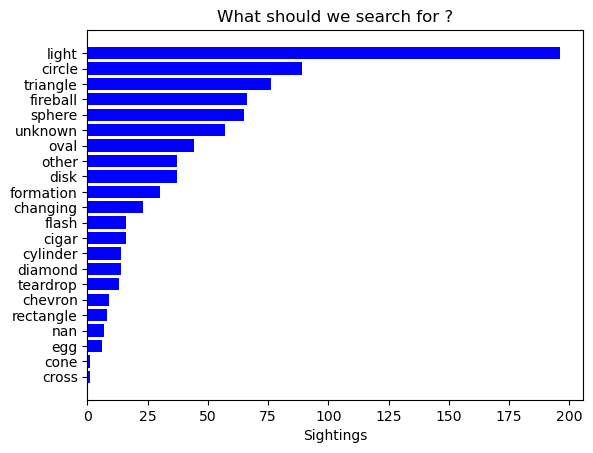

In [4]:
import matplotlib.pyplot as plt
plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = list(shapesdic.keys())
y_pos = np.arange(len(people))
performance = data


ax.barh(y_pos, performance,  align='center',
        color='blue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Sightings')
ax.set_title('What should we search for ?')

plt.show()